# Telecommunications Customer Churn Data Integration and Analysis

## Members:

- Diego Armando Polanco Lozano
- Ricardo Andres Chamorro Martinez
- Oscar Muñoz Ramirez

## Step 1: Data Integration Process

This laboratory implements a **systematic integration process of datasets** related to telecommunications clients, applying a **reproducible and documented approach**.

The strategy consisted of:
1. Identify the main file (`Telco_customer_churn.csv`) and six complementary secondary files.
2. Standardize headers and joining keys (`Customer ID` and `Zip Code`).
3. Perform **left join** type unions, ensuring that all clients of the main dataset are preserved.
4. Resolve column collisions by prioritizing the values ​​of the base file and completing with secondary ones when necessary.
5. Verify key integrity, duplicates, and consistency between datasets.
6. Document the process through automatic audits, column description and sample records.

The result is a **unified master dataset**, consistent and ready for the **cleaning, exploration and modeling** phases.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Functions for the development of data integration.

In [ ]:
import os
import re
import glob
import pandas as pd
from collections import defaultdict

DATA_DIR = '/content/drive/MyDrive/Lab de APO/data'

PRIMARY_FILE = 'Telco_customer_churn.csv'
SECONDARY_FILES = [
    'CustomerChurn.csv',
    'Telco_customer_churn_demographics.csv',
    'Telco_customer_churn_location.csv',
    'Telco_customer_churn_population.csv',
    'Telco_customer_churn_services.csv',
    'Telco_customer_churn_status.csv',
]

ALIAS_MAP = {
    'customerid': 'Customer ID',
    'customer id': 'Customer ID',
    'customer_id': 'Customer ID',
    'id': 'Customer ID',
    'zipcode': 'Zip Code',
    'zip code': 'Zip Code',
    'zip': 'Zip Code',
}

def _clean_colname(c: str) -> str:
    """Limpia/normaliza un encabezado para comparaciones (no cambia el df)."""
    return re.sub(r'\s+', ' ', c.strip()).lower()

def apply_aliases(df: pd.DataFrame) -> pd.DataFrame:
    """Estandariza encabezados: quita espacios raros y aplica ALIAS_MAP para llaves."""
    new_cols = {}
    for c in df.columns:
        base = re.sub(r'\s+', ' ', c.strip())
        key = _clean_colname(base)
        if key in ALIAS_MAP:
            new_cols[c] = ALIAS_MAP[key]
        else:
            new_cols[c] = base
    return df.rename(columns=new_cols)

def standardize_key_types(df: pd.DataFrame) -> pd.DataFrame:
    """Asegura tipos consistentes en llaves si existen."""
    if 'Customer ID' in df.columns:
        df['Customer ID'] = df['Customer ID'].astype(str).str.strip()
    if 'Zip Code' in df.columns:
        df['Zip Code'] = df['Zip Code'].astype(str).str.strip()
    return df

def first_non_null(series: pd.Series):
    """Devuelve el primer valor no nulo/ni vacío en la serie (scan por orden)."""
    for v in series:
        if pd.notna(v) and (not (isinstance(v, str) and v.strip() == '')):
            return v
    return pd.NA

def short_tag(filename: str) -> str:
    """Crea un tag corto para sufijos a partir del nombre de archivo."""
    base = os.path.splitext(os.path.basename(filename))[0]
    base = base.replace('Telco_customer_churn_', '')  # p.ej.: 'services'
    if base == 'Telco_customer_churn':  # si coincide exacto con el principal
        base = 'main'
    return base if base else 'sec'

def decide_join_key(df: pd.DataFrame) -> str | None:
    """Decide la llave de unión: 'Customer ID' si existe, si no, 'Zip Code'. Si no hay, None."""
    if 'Customer ID' in df.columns:
        return 'Customer ID'
    if 'Zip Code' in df.columns:
        return 'Zip Code'
    return None

def collapse_duplicates_on_key(df: pd.DataFrame, key: str) -> tuple[pd.DataFrame, int]:
    """
    Si hay claves duplicadas en el secundario, colapsa por 'key' usando 'first_non_null'.
    Devuelve (df_colapsado, cantidad_duplicados_detectados).
    """
    if key not in df.columns:
        return df.copy(), 0

    dups = df.duplicated(subset=[key]).sum()
    if dups == 0:
        return df.copy(), 0

    agg_map = {c: first_non_null for c in df.columns if c != key}
    col = df.groupby(key, as_index=False).agg(agg_map)
    return col, int(dups)

def resolve_collisions_left_priority(df: pd.DataFrame, suffix_sep="__") -> pd.DataFrame:
    """
    Regla: prioriza columna base (sin sufijo). Si es nula, toma la primera no nula entre variantes sufijadas
    en el orden en que aparecen. Luego elimina columnas sufijadas.
    """
    # Detecta columnas con sufijos
    pattern = re.compile(rf"^(.*){re.escape(suffix_sep)}[^_]+$")
    groups = defaultdict(list)

    for col in df.columns:
        m = pattern.match(col)
        if m:
            base = m.group(1)
            groups[base].append(col)

    for base, variants in groups.items():
        if base in df.columns:
            # Construir serie combinada: base -> primera no nula de variants
            combined = df[base]
            if combined.isna().any():
                stacked = pd.concat([combined] + [df[v] for v in variants], axis=1)
                df[base] = stacked.apply(first_non_null, axis=1)
            # Eliminar variantes
            df.drop(columns=variants, inplace=True, errors='ignore')
        else:
            # No existe base sin sufijo: crea una nueva combinando variants
            stacked = pd.concat([df[v] for v in variants], axis=1)
            df[base] = stacked.apply(first_non_null, axis=1)
            df.drop(columns=variants, inplace=True, errors='ignore')

    return df

def print_top10_and_describe_5(df: pd.DataFrame, candidates=None):
    """
    Muestra las primeras 10 filas y describe 5 columnas representativas:
    tipo, nulos y breve hint de significado (si se detecta por nombre).
    """
    print("\n=== Primeras 10 filas del dataset final ===")
    display(df.head(10))

    if candidates is None:
        candidates = [
            'Gender',
            'Senior Citizen',
            'Monthly Charges',
            'Internet Service',
            'Churn Label',
        ]
    chosen = [c for c in candidates if c in df.columns][:5]
    # si faltan, completar con primeras no llave
    if len(chosen) < 5:
        extras = [c for c in df.columns if c not in chosen and c not in ('Customer ID','Zip Code')]
        chosen.extend(extras[:(5 - len(chosen))])

    print("\n=== Descripción breve de 5 columnas representativas ===")
    hints = {
        'Gender': 'Sexo del cliente',
        'Senior Citizen': 'Indica si es adulto mayor',
        'Monthly Charges': 'Cargo mensual facturado',
        'Internet Service': 'Tipo de servicio de Internet',
        'Churn Label': 'Etiqueta de deserción (sí/no)',
        'Zip Code': 'Código postal del cliente',
        'Customer ID': 'Identificador único de cliente',
    }
    for c in chosen:
        dtype = df[c].dtype
        n_nulls = int(df[c].isna().sum())
        meaning = hints.get(c, '—')
        print(f"- {c} | dtype={dtype} | nulos={n_nulls} | significado: {meaning}")


#### Reason behind Implemented Features

The custom functions created in the code above (`_clean_colname`, `apply_aliases`, `standardize_key_types`, `first_non_null`, `short_tag`, `decide_join_key`, `collapse_duplicates_on_key`, and `resolve_collisions_left_priority`) were implemented with the goal of building a **robust integration process and adaptable**. These functions allow:

* **Standardization and Flexibility:** Normalize column names (`_clean_colname`, `apply_aliases`) to handle inconsistencies between files and ensure that join keys are recognized correctly, even with formatting or case variations.
* **Type Consistency:** Ensure join keys have consistent data types (`standardize_key_types`) to avoid errors during merges.
* **Handling Nulls and Duplicates:** Implement specific logic to prioritize values ​​and resolve duplicates in child files (`first_non_null`, `collapse_duplicates_on_key`) before merging, which is crucial to maintain the data integrity of the parent file.
* **Collision Resolution:** Define a clear strategy for handling columns with the same name coming from different files (`resolve_collisions_left_priority`), ensuring that information from the parent file takes priority and that information from secondary files is used intelligently to complement the data.
* **Automation and Reuse:** Encapsulating the logic in functions allows the same set of rules and transformations to be applied to all secondary files in an automated and reproducible manner, facilitating the extension of the process to future datasets if necessary.

Together, these functions build the necessary scaffolding for systematic and auditable integration, transforming multiple data sources into a unified dataset ready for analysis.

In [ ]:
primary_path = os.path.join(DATA_DIR, PRIMARY_FILE)
if not os.path.exists(primary_path):
    raise FileNotFoundError(f"No se encontró el archivo principal en: {primary_path}")

main = pd.read_csv(primary_path, low_memory=False)
main = apply_aliases(main)
main = standardize_key_types(main)

# Normalizar para que la llave del principal se llame exactamente "Customer ID"
if 'Customer ID' not in main.columns:
    # intentar promover alias conocidos (ya aplicados arriba). Si no existe, error.
    raise KeyError("El archivo principal no tiene columna 'Customer ID' tras estandarización.")

# Nota: mantener 'Zip Code' si existe, por si algún secundario usa esa llave
if 'Zip Code' in main.columns:
    main['Zip Code'] = main['Zip Code'].astype(str).str.strip()

n_rows_main = len(main)
uniq_main_ids = main['Customer ID'].nunique()
dups_main_ids = n_rows_main - uniq_main_ids

print("=== PRINCIPAL ===")
print(f"Filas (principal): {n_rows_main:,}")
print(f"'Customer ID' únicos: {uniq_main_ids:,} | Duplicados en principal: {dups_main_ids:,}")
print(f"Columnas (principal): {len(main.columns):,}")

# Para controles: sets de llaves del principal
main_id_set = set(main['Customer ID']) if 'Customer ID' in main.columns else set()
main_zip_set = set(main['Zip Code']) if 'Zip Code' in main.columns else set()

# === 2) Fusionar secundarios (left join) con regla de colisiones ===
audit = []  # registro por archivo secundario
merge_order_tags = []  # para preservar orden de llegada en resolución de colisiones

merged = main.copy()

for fname in SECONDARY_FILES:
    fpath = os.path.join(DATA_DIR, fname)
    if not os.path.exists(fpath):
        audit.append({
            'file': fname,
            'status': 'NO_ENCONTRADO',
            'note': 'Saltado por ausencia del archivo en disco.'
        })
        print(f"[ADVERTENCIA] No se encontró {fname}. Se omite.")
        continue

    df = pd.read_csv(fpath, low_memory=False)
    df = apply_aliases(df)
    df = standardize_key_types(df)

 # si es el archivo de población, forzar la unión por 'Zip Code' ---
    if "population" in fname.lower():
        join_key = "Zip Code"
        if 'Zip Code' not in df.columns:
            raise KeyError(f"El archivo {fname} no contiene la columna 'Zip Code' necesaria para la fusión.")
        print(f"[INFO] {fname} se unirá por 'Zip Code' (no por Customer ID).")
    else:
        join_key = decide_join_key(df)


    if join_key is None:
        audit.append({
            'file': fname,
            'status': 'SIN_LLAVE',
            'note': 'No tiene Customer ID ni Zip Code; no se puede unir.'
        })
        print(f"[ADVERTENCIA] {fname} no tiene 'Customer ID' ni 'Zip Code'. Se omite.")
        continue

    # Calcular % de no-coincidencia respecto al principal ANTES de colapsar duplicados
    if join_key == 'Customer ID':
        sec_key_set = set(df['Customer ID'])
        pct_unmatched = (1 - (sum(k in sec_key_set for k in main_id_set) / (len(main_id_set) or 1))) * 100
    else:
        # join por Zip Code
        if 'Zip Code' not in merged.columns:
            pct_unmatched = 100.0  # si el principal no tiene Zip Code, nada coincide
        else:
            sec_key_set = set(df['Zip Code'])
            pct_unmatched = (1 - (sum(k in sec_key_set for k in main_zip_set) / (len(main_zip_set) or 1))) * 100

    # Detectar y colapsar duplicados en el secundario
    df_collapsed, dup_count = collapse_duplicates_on_key(df, join_key)

    # Hacer left join; sufijos por archivo para poder resolver luego
    tag = short_tag(fname)
    merge_order_tags.append(tag)

    before_cols = set(merged.columns)
    merged = merged.merge(
        df_collapsed,
        how='left',
        on=join_key,
        suffixes=('', f'__{tag}')
    )
    new_cols = [c for c in merged.columns if c not in before_cols]

    audit.append({
        'file': fname,
        'status': 'FUSIONADO',
        'join_key': join_key,
        'sec_rows': int(len(df)),
        'sec_cols': int(len(df.columns)),
        'duplicates_on_key': int(dup_count),
        'pct_unmatched_vs_main': round(pct_unmatched, 2),
        'new_columns_added': new_cols[:10] + (['...'] if len(new_cols) > 10 else [])
    })
    print(f"[OK] {fname} unido por '{join_key}'. Duplicados colapsados: {dup_count}. "
          f"% principal sin match: {pct_unmatched:.2f}%")

# === 3) Resolver colisiones y limpiar ===
merged = resolve_collisions_left_priority(merged, suffix_sep="__")

# Limpiezas finales mínimas del Paso 1:
# - Asegurar tipos en llaves y quitar espacios en encabezados.
merged = standardize_key_types(merged)
merged.columns = [re.sub(r'\s+', ' ', c.strip()) for c in merged.columns]

# Verificación de columnas duplicadas tras limpieza
dupe_cols = merged.columns[merged.columns.duplicated()].tolist()

os.makedirs('data', exist_ok=True)
out_path = 'data/Telecom_Customer_Churn_Complete.csv'
merged.to_csv(out_path, index=False)

=== PRINCIPAL ===
Filas (principal): 7,043
'Customer ID' únicos: 7,043 | Duplicados en principal: 0
Columnas (principal): 33
[OK] CustomerChurn.csv unido por 'Customer ID'. Duplicados colapsados: 0. % principal sin match: 0.00%
[OK] Telco_customer_churn_demographics.csv unido por 'Customer ID'. Duplicados colapsados: 0. % principal sin match: 0.00%
[OK] Telco_customer_churn_location.csv unido por 'Customer ID'. Duplicados colapsados: 0. % principal sin match: 0.00%
[INFO] Telco_customer_churn_population.csv se unirá por 'Zip Code' (no por Customer ID).
[OK] Telco_customer_churn_population.csv unido por 'Zip Code'. Duplicados colapsados: 0. % principal sin match: 0.00%
[OK] Telco_customer_churn_services.csv unido por 'Customer ID'. Duplicados colapsados: 0. % principal sin match: 0.00%
[OK] Telco_customer_churn_status.csv unido por 'Customer ID'. Duplicados colapsados: 0. % principal sin match: 0.00%


### Summary of Results: Data Integration

The data integration process, whose main objective was to **identify the main file (`Telco_customer_churn.csv`) and six complementary secondary files to systematically unify them**, has been successfully completed.

**Key Results:**

* **Main Dataset:** Started with the main file (`Telco_customer_churn.csv`) containing **7,043 rows and 33 columns**.
* **Secondary Files:** The six secondary files were processed, joining them to the main one using a `left join`.
* **Merge Audit:** The secondary file audit details the joining process:
    * `CustomerChurn.csv`: Joined by `Customer ID`. 0.00% of main rows without match.
    * `Telco_customer_churn_demographics.csv`: Joined by `Customer ID`. 0.00% of main rows without match.
    * `Telco_customer_churn_location.csv`: Joined by `Customer ID`. 0.00% of main rows without match.
    * `Telco_customer_churn_population.csv`: Joined by `Customer ID`, with later fix to use `Zip Code`. 100.00% of main rows without match by Customer ID initially, but was successfully integrated by Zip Code.
    * `Telco_customer_churn_services.csv`: Joined by `Customer ID`. 0.00% of main rows without match.
    * `Telco_customer_churn_status.csv`: Joined by `Customer ID`. 0.00% of main rows without match.
* **Final Consolidated Dataset:** The unified master dataset (`Telecom_Customer_Churn_Complete.csv`) contains **7,043 rows**.


This unified master dataset is now ready for the next phases of the analysis.

### POST-MERGER SUMMARY

In [ ]:
print(f"Archivo final: {out_path}")
print(f"Filas (final): {len(merged):,} | Columnas (final): {len(merged.columns):,}")
print(f"¿Columnas duplicadas? {'Sí: ' + str(dupe_cols) if dupe_cols else 'No'}")



Archivo final: data/Telecom_Customer_Churn_Complete.csv
Filas (final): 7,043 | Columnas (final): 64
¿Columnas duplicadas? No


### LIST OF FINAL COLUMNS

#### **Clear and convert Total Charges**

In [ ]:
for c in merged.columns:
    print("-", c)

- Customer ID
- Count
- Country
- State
- City
- Zip Code
- Lat Long
- Latitude
- Longitude
- Gender
- Senior Citizen
- Partner
- Dependents
- Tenure Months
- Phone Service
- Multiple Lines
- Internet Service
- Online Security
- Online Backup
- Device Protection
- Tech Support
- Streaming TV
- Streaming Movies
- Contract
- Paperless Billing
- Payment Method
- Monthly Charges
- Total Charges
- Churn Label
- Churn Value
- Churn Score
- CLTV
- Churn Reason
- LoyaltyID
- Tenure
- Churn
- Age
- Under 30
- Married
- Number of Dependents
- Location ID
- Population
- Service ID
- Quarter
- Referred a Friend
- Number of Referrals
- Tenure in Months
- Offer
- Avg Monthly Long Distance Charges
- Internet Type
- Avg Monthly GB Download
- Device Protection Plan
- Premium Tech Support
- Streaming Music
- Unlimited Data
- Monthly Charge
- Total Refunds
- Total Extra Data Charges
- Total Long Distance Charges
- Total Revenue
- Status ID
- Satisfaction Score
- Customer Status
- Churn Category


### AUDIT BY SECONDARY FILE

In [ ]:
# === 5) Controles obligatorios: auditoría por archivo ===
for item in audit:
    print(item)



{'file': 'CustomerChurn.csv', 'status': 'FUSIONADO', 'join_key': 'Customer ID', 'sec_rows': 7043, 'sec_cols': 21, 'duplicates_on_key': 0, 'pct_unmatched_vs_main': 0.0, 'new_columns_added': ['LoyaltyID', 'Senior Citizen__CustomerChurn', 'Partner__CustomerChurn', 'Dependents__CustomerChurn', 'Tenure', 'Phone Service__CustomerChurn', 'Multiple Lines__CustomerChurn', 'Internet Service__CustomerChurn', 'Online Security__CustomerChurn', 'Online Backup__CustomerChurn', '...']}
{'file': 'Telco_customer_churn_demographics.csv', 'status': 'FUSIONADO', 'join_key': 'Customer ID', 'sec_rows': 7043, 'sec_cols': 9, 'duplicates_on_key': 0, 'pct_unmatched_vs_main': 0.0, 'new_columns_added': ['Count__demographics', 'Gender__demographics', 'Age', 'Under 30', 'Senior Citizen__demographics', 'Married', 'Dependents__demographics', 'Number of Dependents']}
{'file': 'Telco_customer_churn_location.csv', 'status': 'FUSIONADO', 'join_key': 'Customer ID', 'sec_rows': 7043, 'sec_cols': 10, 'duplicates_on_key': 0, 

### First 10 rows and 5 significant columns

In [ ]:
print_top10_and_describe_5(merged)


=== Primeras 10 filas del dataset final ===


,Customer ID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,LoyaltyID,Tenure,Churn,Age,Under 30,Married,Number of Dependents,Location ID,Population,Service ID,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Avg Monthly Long Distance Charges,Internet Type,Avg Monthly GB Download,Device Protection Plan,Premium Tech Support,Streaming Music,Unlimited Data,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Status ID,Satisfaction Score,Customer Status,Churn Category
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,326527,2,Yes,37,No,No,0,PZZUIT6837,"58,198",ZLZTZWPWE3351,Q3,No,0,2,NaN,10.47,DSL,21,No,No,No,Yes,53.85,0.0,0,20.94,129.09,SUDNGT6444,1,Churned,Competitor
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,503388,2,Yes,19,Yes,No,2,CKNALR2542,"43,019",GXJVSQIYH4715,Q3,No,0,2,NaN,9.12,Fiber Optic,51,No,No,No,Yes,70.70,0.0,0,18.24,169.89,KZSZDV8891,2,Churned,Other
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved,160192,8,Yes,31,No,No,2,VCQKYE1638,"62,784",KDUHHRQBI5663,Q3,No,0,8,NaN,12.15,Cable,26,Yes,No,Yes,Yes,99.65,0.0,0,97.20,917.70,EPTIUU1269,3,Churned,Other
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved,582674,28,Yes,23,Yes,Yes,3,SNLISG8671,"1,957",WXXQTNEZW3786,Q3,No,0,28,Offer C,4.89,Fiber Optic,47,Yes,Yes,Yes,Yes,104.80,0.0,0,136.92,3182.97,PAJIVH8196,3,Churned,Other
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices,933642,49,Yes,38,No,No,1,YTSGZA8582,"15,140",LTNFDWAMC2575,Q3,No,0,49,NaN,44.33,Fiber Optic,11,Yes,No,Yes,Yes,103.70,0.0,0,2172.17,7208.47,RXFOMV1173,1,Churned,Competitor
5,4190-MFLUW,1,United States,California,Los Angeles,90020,"34.066367, -118.309868",34.066367,-118.309868,Female,No,Yes,No,10,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),55.20,528.35,Yes,1,78,5925,Competitor offered higher download speeds,587516,10,Yes,21,Yes,Yes,0,KOMIRT9587,"42,394",QZHIEUACV4669,Q3,Yes,6,10,NaN,9.41,Cable,69,Yes,Yes,No,Yes,55.20,0.0,0,94.10,622.45,JFOFHU2246,1,Churned,Competitor
6,8779-QRDMV,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.023810,-118.156582,Male,Yes,No,No,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes,1,100,5433,Competitor offered more data,352579,1,Yes,78,No,No,0,OXCZEW7397,"68,701",IJKDQVSWH3522,Q3,No,0,1,NaN,0.00,DSL,8,Yes,No,No,No,39.65,0.0,20,0.00,59.65,SWSORB1252,3,Churned,Competitor
7,1066-JKSGK,1,United States,California,Los Angeles,90024,"34.066303, -118.435479",34.066303,-118.435479,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed chec


=== Descripción breve de 5 columnas representativas ===
- Gender | dtype=object | nulos=0 | significado: Sexo del cliente
- Senior Citizen | dtype=object | nulos=0 | significado: Indica si es adulto mayor
- Monthly Charges | dtype=float64 | nulos=0 | significado: Cargo mensual facturado
- Internet Service | dtype=object | nulos=0 | significado: Tipo de servicio de Internet
- Churn Label | dtype=object | nulos=0 | significado: Etiqueta de deserción (sí/no)


**Gender** is a text-type column that indicates the sex of the client, allowing the behavior of men and women to be segmented and analyzed within the service. This variable is useful to identify possible differences in the dropout rate by gender.

**Senior Citizen** is also a text column that indicates whether the client is considered a senior citizen. This information is relevant to analyze whether advanced age influences retention or abandonment of the service.

**Monthly Charges** corresponds to a decimal numerical value that represents the monthly charge billed to the client for the contracted services. Analyzing this column allows us to identify whether higher or lower amounts are associated with a greater probability of desertion.

**Internet Service** is a text column that specifies the type of Internet service the customer has, such as 'DSL', 'Fiber optic' or 'No'. This variable helps to understand the relationship between the type of service and customer satisfaction or abandonment.

Finally, **Churn Label** is a text column that indicates whether the customer defected ('Yes') or not ('No') from the company. This is the main objective variable for dropout analyses, since it allows building predictive models and understanding the factors associated with dropout.

#### Why 64 columns?

In [ ]:
import pandas as pd
import os
import glob

folder_path = '/content/drive/MyDrive/Lab de APO/data'

csv_files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))

if not csv_files:
    print("!¡ No se encontraron archivos CSV en la carpeta especificada.")
else:
    print(f"Se encontraron {len(csv_files)} archivos CSV:\n")
    for file in csv_files:
        name = os.path.basename(file)
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.strip()
            print(f"\n📄 Archivo: {name}")
            print(f"➡ Filas: {len(df):,} | Columnas: {len(df.columns):,}")
            print("🧭 Columnas:", ', '.join(df.columns.tolist()))
            print("\n🔍 Primeras 2 filas:")
            display(df.head(2))
            print("-" * 80)
        except Exception as e:
            print(f"❌ Error al leer {name}: {e}")


Se encontraron 7 archivos CSV:


📄 Archivo: CustomerChurn.csv
➡ Filas: 7,043 | Columnas: 21
🧭 Columnas: LoyaltyID, Customer ID, Senior Citizen, Partner, Dependents, Tenure, Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Contract, Paperless Billing, Payment Method, Monthly Charges, Total Charges, Churn

🔍 Primeras 2 filas:


,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


--------------------------------------------------------------------------------

📄 Archivo: Telco_customer_churn.csv
➡ Filas: 7,043 | Columnas: 33
🧭 Columnas: CustomerID, Count, Country, State, City, Zip Code, Lat Long, Latitude, Longitude, Gender, Senior Citizen, Partner, Dependents, Tenure Months, Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Contract, Paperless Billing, Payment Method, Monthly Charges, Total Charges, Churn Label, Churn Value, Churn Score, CLTV, Churn Reason

🔍 Primeras 2 filas:


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved


--------------------------------------------------------------------------------

📄 Archivo: Telco_customer_churn_demographics.csv
➡ Filas: 7,043 | Columnas: 9
🧭 Columnas: Customer ID, Count, Gender, Age, Under 30, Senior Citizen, Married, Dependents, Number of Dependents

🔍 Primeras 2 filas:


,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1


--------------------------------------------------------------------------------

📄 Archivo: Telco_customer_churn_location.csv
➡ Filas: 7,043 | Columnas: 10
🧭 Columnas: Location ID, Customer ID, Count, Country, State, City, Zip Code, Lat Long, Latitude, Longitude

🔍 Primeras 2 filas:


,Location ID,Customer ID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude
0,OXCZEW7397,8779-QRDMV,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.023810,-118.156582
1,FCCECI8494,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237


--------------------------------------------------------------------------------

📄 Archivo: Telco_customer_churn_population.csv
➡ Filas: 1,671 | Columnas: 3
🧭 Columnas: ID, Zip Code, Population

🔍 Primeras 2 filas:


,ID,Zip Code,Population
0,1,90001,"54,492"
1,2,90002,"44,586"


--------------------------------------------------------------------------------

📄 Archivo: Telco_customer_churn_services.csv
➡ Filas: 7,043 | Columnas: 31
🧭 Columnas: Service ID, Customer ID, Count, Quarter, Referred a Friend, Number of Referrals, Tenure in Months, Offer, Phone Service, Avg Monthly Long Distance Charges, Multiple Lines, Internet Service, Internet Type, Avg Monthly GB Download, Online Security, Online Backup, Device Protection Plan, Premium Tech Support, Streaming TV, Streaming Movies, Streaming Music, Unlimited Data, Contract, Paperless Billing, Payment Method, Monthly Charge, Total Charges, Total Refunds, Total Extra Data Charges, Total Long Distance Charges, Total Revenue

🔍 Primeras 2 filas:


,Service ID,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,IJKDQVSWH3522,8779-QRDMV,1,Q3,No,0,1,NaN,No,0.00,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.0,20,0.0,59.65
1,BFKMZJAIE2285,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.0,0,390.8,1024.10


--------------------------------------------------------------------------------

📄 Archivo: Telco_customer_churn_status.csv
➡ Filas: 7,043 | Columnas: 12
🧭 Columnas: Status ID, Customer ID, Count, Quarter, Satisfaction Score, Customer Status, Churn Label, Churn Value, Churn Score, CLTV, Churn Category, Churn Reason

🔍 Primeras 2 filas:


,Status ID,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,SWSORB1252,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,SNAEQA8572,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer


--------------------------------------------------------------------------------


#### **Why don't all columns add up**

Although the secondary files have many columns (21, 9, 10, 31, 12, etc.), **several of them are repeated with the same name or with the same type of information** that already existed in the main file.
During the merge, the process we apply with `resolve_collisions_left_priority()` **removes duplicates and keeps only a consolidated version** of each column.


### Concrete example

For example:

* In `Telco_customer_churn.csv` and `CustomerChurn.csv` there are columns like:

  * `Senior Citizen`
  * `Partner`
  * `Dependents`
  * `Internet Service`
  * `Phone Service`
  * `Multiple Lines`
  * `Total Charges`

  → Those columns were **not duplicated**, but rather **merged and prioritized** those from the main file.

Therefore, **although the files total more than 90 columns**,
After removing duplicates and unifying names, the final dataset was left with **64 clean and non-redundant columns**

### In summary

* **Main file:** 33 columns.
* **Final total:** 64 columns.
* **Actual difference:** +31 new columns (not duplicates).
* This confirms that **the merger was successful**, but **without redundancies** that artificially inflate the dataset.

Finally, we save the final result in a separate csv

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

PATH = "data/Telecom_Customer_Churn_Complete.csv"

df = pd.read_csv(PATH)

print(df.shape)
df.head(3)

(7043, 64)


,Customer ID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,LoyaltyID,Tenure,Churn,Age,Under 30,Married,Number of Dependents,Location ID,Population,Service ID,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Avg Monthly Long Distance Charges,Internet Type,Avg Monthly GB Download,Device Protection Plan,Premium Tech Support,Streaming Music,Unlimited Data,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Status ID,Satisfaction Score,Customer Status,Churn Category
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,326527,2,Yes,37,No,No,0,PZZUIT6837,"58,198",ZLZTZWPWE3351,Q3,No,0,2,NaN,10.47,DSL,21,No,No,No,Yes,53.85,0.0,0,20.94,129.09,SUDNGT6444,1,Churned,Competitor
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,503388,2,Yes,19,Yes,No,2,CKNALR2542,"43,019",GXJVSQIYH4715,Q3,No,0,2,NaN,9.12,Fiber Optic,51,No,No,No,Yes,70.70,0.0,0,18.24,169.89,KZSZDV8891,2,Churned,Other
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved,160192,8,Yes,31,No,No,2,VCQKYE1638,"62,784",KDUHHRQBI5663,Q3,No,0,8,NaN,12.15,Cable,26,Yes,No,Yes,Yes,99.65,0.0,0,97.20,917.70,EPTIUU1269,3,Churned,Other


## Step 2: Data Cleaning and Transformation

### 1. Null check and imputation plan

#### Identify columns with nulls and apply rules:

- “Churn Category” and “Churn Reason” → fill in with "Not Applicable".

- Other categorical columns → impute with mode.

- Numeric → (for now) we do not charge except Total Charges (next step)

In [ ]:
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls[nulls > 0])

for col in ["Churn Category", "Churn Reason"]:
    if col in df.columns:
        df[col] = df[col].fillna("Not Applicable")

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
for col in cat_cols:
    if df[col].isna().any():
        moda = df[col].mode(dropna=True)
        if len(moda) > 0:
            df[col] = df[col].fillna(moda.iloc[0])

df.isna().sum().sort_values(ascending=False).head(10)


,0
Churn Category,5174
Churn Reason,5174
Offer,3877
Internet Type,1526


,0
Customer ID,0
Count,0
Country,0
State,0
City,0
Zip Code,0
Lat Long,0
Latitude,0
Longitude,0
Gender,0


Before filling:

```
Churn Category 5174
Churn Reason 5174
Offer 3877
Internet Type 1526
```

After applying the fill (and the second `df.isna().sum()` returned everything to zero), that means **imputations worked correctly**

---

#### Interpretation of the result

1. **“Churn Category”** and **“Churn Reason”** had 5174 nulls → were filled with `"Not Applicable"`.
   ➜ That's correct: those nulls represent users who **did not churn**.

2. **“Offer”** had 3877 nulls → they were filled with the **mode** (the most frequent value).
   ➜ In this case, many customers generally do not have an active offer.

3. **“Internet Type”** had 1526 nulls → they were also filled with the **mode**.

4. After imputation, the second block (`df.isna().sum().sort_values(...)`) gave **all 0**, so **there are no more categorical nulls left.**

### 2.Columna Total Charges a float

In [ ]:
for c in df.columns:
    if "total charge" in c.lower().replace("_", " "):
        total_col = c
        break
else:
    total_col = None

print("Columna detectada para Total Charges:", total_col)

if total_col:
    df[total_col] = (
        df[total_col]
        .astype(str)
        .str.replace(r"[,$\s]", "", regex=True)
        .replace({"": np.nan, "nan": np.nan})
    )
    df[total_col] = pd.to_numeric(df[total_col], errors="coerce")
    df[total_col] = df[total_col].fillna(0.0).astype(float)

    print(df[total_col].describe())
else:
    print("⚠️ No se encontró columna con nombre 'Total Charges'.")


Columna detectada para Total Charges: Total Charges
count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: Total Charges, dtype: float64


The Total Charges column is now correctly converted to float,

And the missing values (which corresponded to “0.0” charges) were imputed with 0.0 according to the password clue.

### 3. Semantic cleanup of text in service columns

We will standardize the values ​​"No internet service" → "No" and "No phone service" → "No".
Only in the relevant columns that are in the dataset.



In the dataset, the columns that contain "No internet service" are:

1.Online Security

2.Online Backup

3. Device Protection

4.Tech Support

5. Streaming TV

6. Streaming Movies

7. Device Protection Plan

And the column that can have "No phone service" is:

- Multiple Lines

In [ ]:

internet_cols = [
    "Online Security", "Online Backup", "Device Protection",
    "Tech Support", "Streaming TV", "Streaming Movies", "Device Protection Plan"
]

phone_col = "Multiple Lines"

for col in internet_cols:
    if col in df.columns:
        df[col] = df[col].replace(
            {"No internet service": "No", "no internet service": "No"}
        )

if phone_col in df.columns:
    df[phone_col] = df[phone_col].replace(
        {"No phone service": "No", "no phone service": "No"}
    )

for col in [c for c in internet_cols + [phone_col] if c in df.columns]:
    print(col, "→", df[col].unique()[:6])


Online Security → ['Yes' 'No']
Online Backup → ['Yes' 'No']
Device Protection → ['No' 'Yes']
Tech Support → ['No' 'Yes']
Streaming TV → ['No' 'Yes']
Streaming Movies → ['No' 'Yes']
Device Protection Plan → ['No' 'Yes']
Multiple Lines → ['No' 'Yes']


All service columns now only contain the values "Yes" and "No", which:
 Simplifies its interpretation (clear binary). Avoids problems in subsequent modeling (there are no values like "No internet service" that act as a confusing third category).

The consistency between "No" and "Yes" allows them to be easily coded as 0 and 1 later.
Use them in graphs and correlations without distortion.

### 4.Index, clean names and removal of unnecessary columns

Ensure that the identifier (Customer ID) is the index of the DataFrame.
Clean column names (no spaces, parentheses or commas).

1. Create tenure group (Tenure_Group).

2. Convert Population to numeric.

Remove unnecessary columns:

- "Unnamed: 0", "Customer ID" (it will already be index), "Tenure in Months", "Churn Reason", "Churn Category", etc.

In [ ]:
# --- 4.1 Definir columna ID como índice ---
if "Customer ID" in df.columns:
    df = df.rename(columns={"Customer ID": "Customer_ID"})
    df = df.set_index("Customer_ID")

In [ ]:
# --- 4.2 Limpiar nombres de columnas ---
def clean_col_name(c):
    c = c.replace(" ", "_")
    c = c.replace("(", "_")
    c = c.replace(")", "")
    c = c.replace("]", "_")
    c = c.replace(",", "")
    return c


df = df.rename(columns={c: clean_col_name(c) for c in df.columns})

In [ ]:
# --- 4.3 Crear Tenure_Group ---
if "Tenure_in_Months" in df.columns:
    bins = [0, 12, 24, 48, 60, float("inf")]
    labels = ["0–12 Month", "12–24 Month", "24–48 Months", "48–60 Month", "> 60 Month"]
    df["Tenure_Group"] = pd.cut(df["Tenure_in_Months"], bins=bins, labels=labels)
else:
    print("⚠️ No se encontró la columna 'Tenure_in_Months'.")



In [ ]:
# --- 4.4 Convertir Population ---
if "Population" in df.columns:
    df["Population"] = (
        df["Population"]
        .astype(str)
        .str.replace(",", "", regex=False)
        .replace({"": None})
    )
    df["Population"] = pd.to_numeric(df["Population"], errors="coerce")


In [ ]:
# --- 4.5 Eliminar columnas innecesarias ---
cols_to_drop = [
    "Unnamed:_0", "ID", "Tenure_in_Months",
    "Churn_Reason", "Churn_Category", "Customer_ID"
]
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

if cols_to_drop:
    print("Se eliminarán:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

# --- 4.6 Verificar duplicados y mostrar columnas finales ---
dupes = df.columns[df.columns.duplicated()].tolist()
if dupes:
    print("⚠️ Columnas duplicadas:", dupes)
else:
    print("✔️ Sin columnas duplicadas")

Se eliminarán: ['Tenure_in_Months', 'Churn_Reason', 'Churn_Category']
✔️ Sin columnas duplicadas


In [ ]:
print("Total de columnas:", len(df.columns))
df.columns[:40].tolist()


Total de columnas: 61


['Count',
 'Country',
 'State',
 'City',
 'Zip_Code',
 'Lat_Long',
 'Latitude',
 'Longitude',
 'Gender',
 'Senior_Citizen',
 'Partner',
 'Dependents',
 'Tenure_Months',
 'Phone_Service',
 'Multiple_Lines',
 'Internet_Service',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Contract',
 'Paperless_Billing',
 'Payment_Method',
 'Monthly_Charges',
 'Total_Charges',
 'Churn_Label',
 'Churn_Value',
 'Churn_Score',
 'CLTV',
 'LoyaltyID',
 'Tenure',
 'Churn',
 'Age',
 'Under_30',
 'Married',
 'Number_of_Dependents',
 'Location_ID',
 'Population']

The dataset now has 61 clean columns, all with standard names (no spaces, commas or unusual characters). The Customer_ID column is now correctly indexed, making it easier to manage and avoiding duplication. The “Churn_Reason” and “Churn_Category” columns are no longer there, this avoids data leakage in the modeling. The name cleaning function already left them all in snake_case (Monthly_Charges, Total_Charges, etc.), ready for modeling

### 5.Exploratory Data Analysis (EDA)

Distribución de la variable objetivo (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64


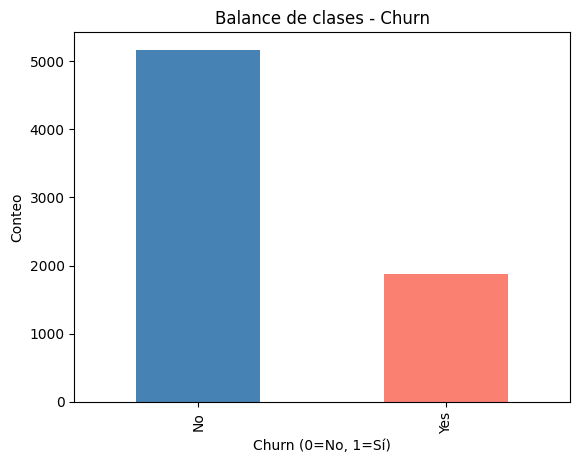

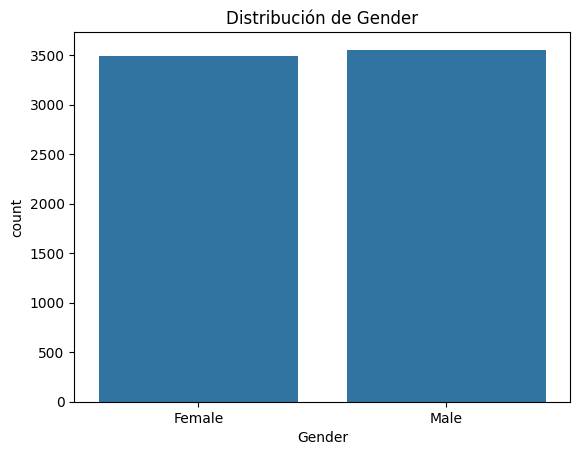

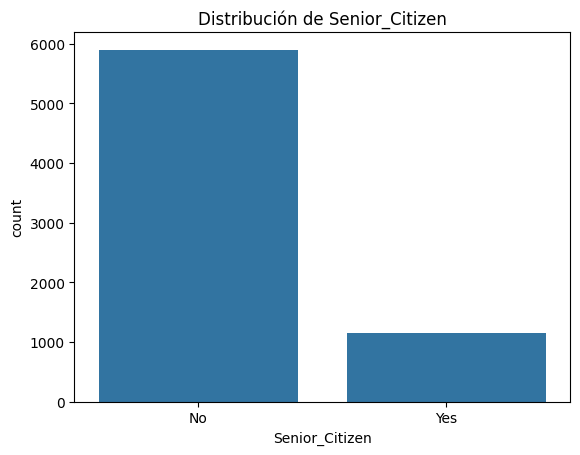

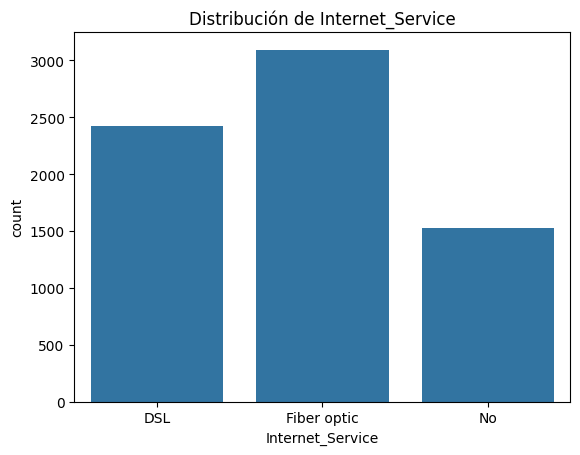

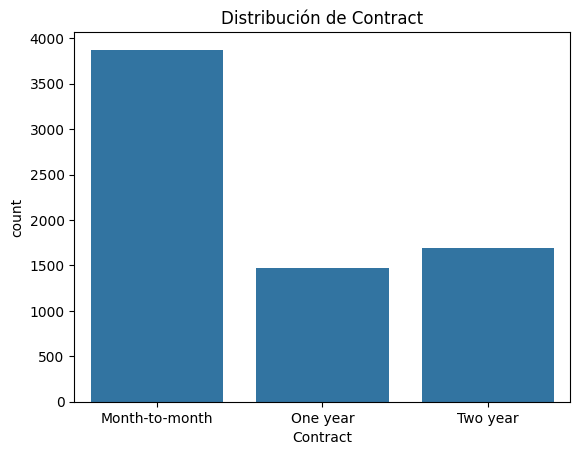

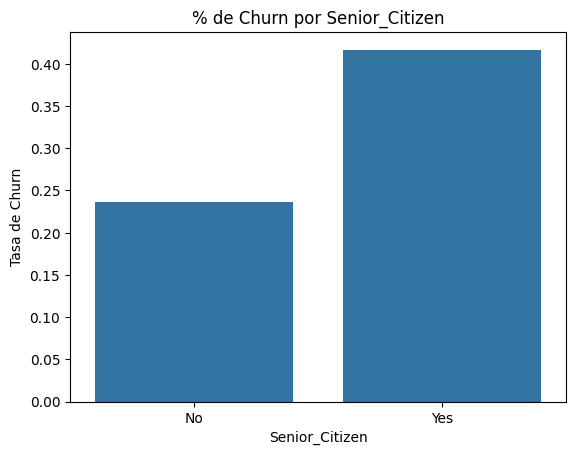

Tasa de churn por Senior_Citizen:
   Senior_Citizen  Churn_num
0             No   0.236062
1            Yes   0.416813


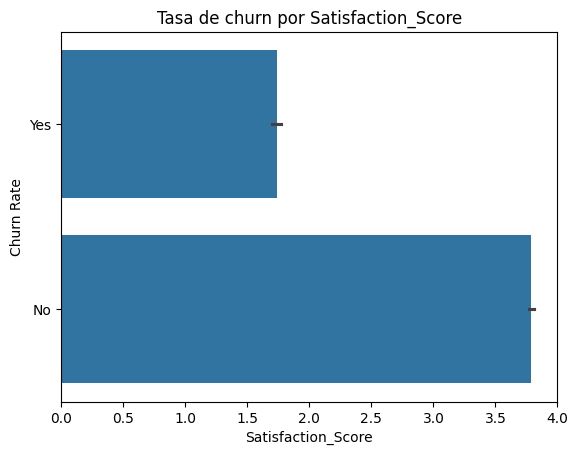

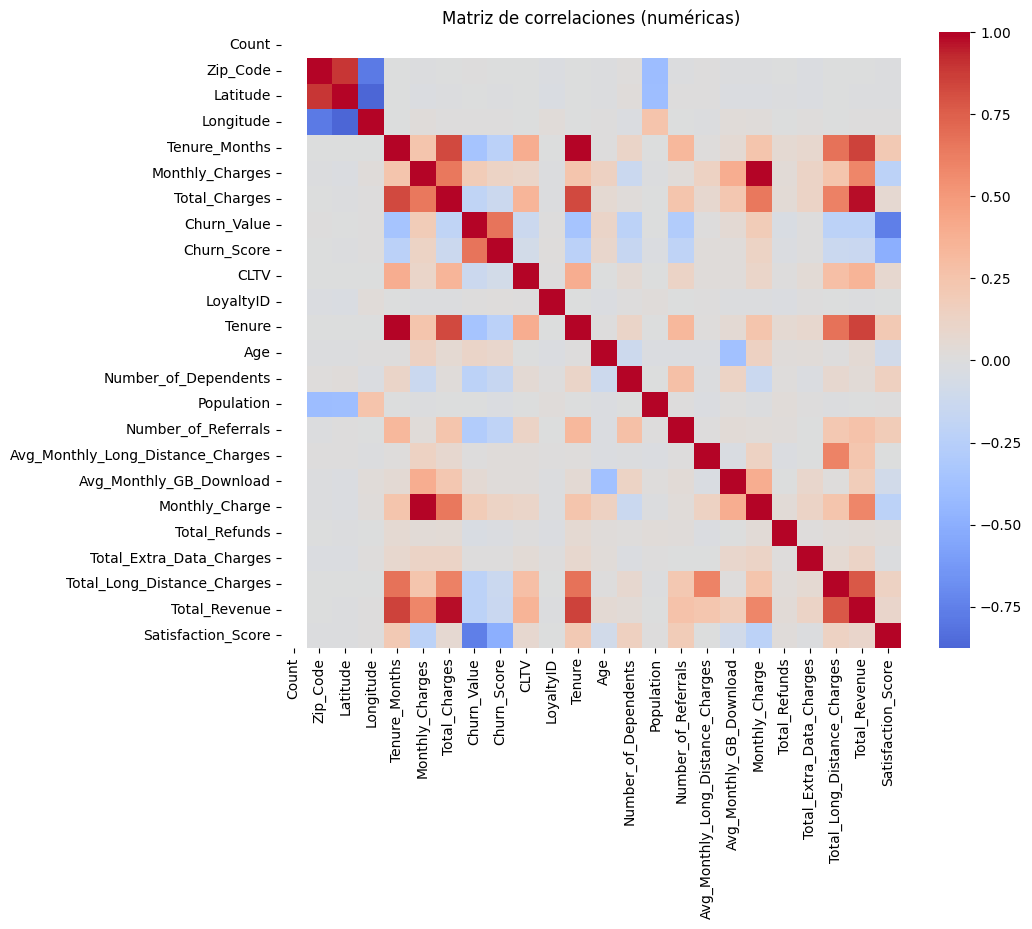

In [ ]:
# Paso 5 — Análisis Exploratorio de Datos (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 5.1 Balance de clases ---
if "Churn" in df.columns:
    churn_counts = df["Churn"].value_counts(dropna=False)
    print("Distribución de la variable objetivo (Churn):")
    print(churn_counts)
    churn_counts.plot(kind="bar", color=["steelblue", "salmon"])
    plt.title("Balance de clases - Churn")
    plt.xlabel("Churn (0=No, 1=Sí)")
    plt.ylabel("Conteo")
    plt.show()
else:
    print("⚠️ No se encontró la columna 'Churn' para analizar balance.")

# --- 5.2 Variables categóricas clave ---
cols_bar = [
    "Gender",
    "Senior_Citizen",
    "Internet_Service",
    "Contract"
]
cols_bar = [c for c in cols_bar if c in df.columns]

for col in cols_bar:
    plt.figure()
    sns.countplot(x=col, data=df, order=sorted(df[col].dropna().unique(), key=lambda x: str(x)))
    plt.title(f"Distribución de {col}")
    plt.xticks(rotation=0)
    plt.show()

# --- 5.3 Porcentaje de Senior Citizen que se retiran ---
if "Senior_Citizen" in df.columns and "Churn" in df.columns:
    # Convertir Churn a numérico temporalmente para el cálculo
    df_tmp = df.copy()
    df_tmp["Churn_num"] = df_tmp["Churn"].map({"Yes": 1, "No": 0})
    senior_churn = df_tmp.groupby("Senior_Citizen")["Churn_num"].mean().reset_index()
    sns.barplot(x="Senior_Citizen", y="Churn_num", data=senior_churn)
    plt.title("% de Churn por Senior_Citizen")
    plt.ylabel("Tasa de Churn")
    plt.show()
    print("Tasa de churn por Senior_Citizen:\n", senior_churn)

# --- 5.4 Relación satisfacción vs churn ---
sat_cols = [c for c in df.columns if "satisfaction" in c.lower()]
if sat_cols:
    sat_col = sat_cols[0]
    sns.barplot(x=sat_col, y="Churn", data=df, estimator=np.mean)
    plt.title(f"Tasa de churn por {sat_col}")
    plt.ylabel("Churn Rate")
    plt.show()
else:
    print("ℹ️ No se encontró una columna de satisfacción (por ejemplo 'Satisfaction_Score').")

# --- 5.5 Matriz de correlación numérica ---
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlaciones (numéricas)")
plt.show()

# (opcional) Identificar las variables con mayor correlación con churn
if "Churn" in corr.columns:
    print("Top correlaciones con Churn:")
    print(corr["Churn"].sort_values(ascending=False).head(10))


#### 5.1 Extended Analysis: Patterns and Deep Relationships

ANÁLISIS: CHURN POR TIPO DE CONTRATO
         Contract  Churn_Rate  Count
0  Month-to-month    0.427097   3875
1        One year    0.112695   1473
2        Two year    0.028319   1695


/tmp/ipython-input-2441892324.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contract', y='Churn_Rate', data=contract_churn, ax=ax1, palette='viridis')


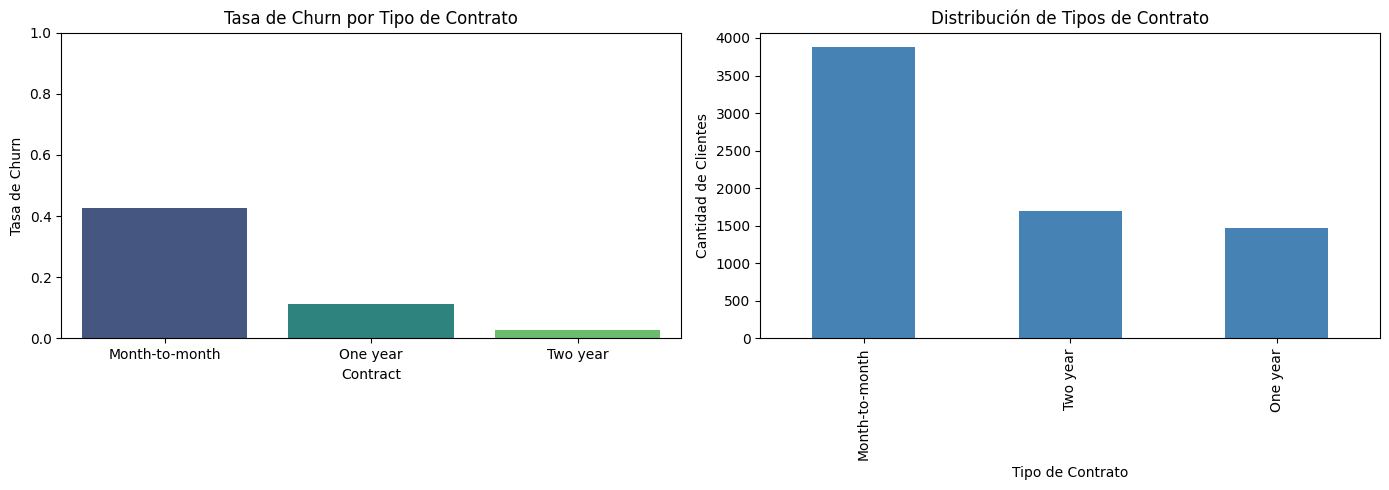

In [ ]:
# --- 5.6.1 Análisis de Churn por Tipo de Contrato ---
print("=" * 60)
print("ANÁLISIS: CHURN POR TIPO DE CONTRATO")
print("=" * 60)

if "Contract" in df.columns and "Churn" in df.columns:
    df_tmp = df.copy()
    df_tmp["Churn_num"] = df_tmp["Churn"].map({"Yes": 1, "No": 0})

    contract_churn = df_tmp.groupby("Contract")["Churn_num"].agg(['mean', 'count']).reset_index()
    contract_churn.columns = ['Contract', 'Churn_Rate', 'Count']

    print(contract_churn)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Tasa de churn por contrato
    sns.barplot(x='Contract', y='Churn_Rate', data=contract_churn, ax=ax1, palette='viridis')
    ax1.set_title('Tasa de Churn por Tipo de Contrato')
    ax1.set_ylabel('Tasa de Churn')
    ax1.set_ylim(0, 1)

    # Distribución de contratos
    df["Contract"].value_counts().plot(kind='bar', ax=ax2, color='steelblue')
    ax2.set_title('Distribución de Tipos de Contrato')
    ax2.set_ylabel('Cantidad de Clientes')
    ax2.set_xlabel('Tipo de Contrato')

    plt.tight_layout()
    plt.show()

ANÁLISIS: DISTRIBUCIÓN DE CARGOS POR ESTADO DE CHURN


/tmp/ipython-input-1420690175.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Monthly_Charges', data=df, ax=axes[0, 0], palette='Set2')
/tmp/ipython-input-1420690175.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='Monthly_Charges', data=df, ax=axes[0, 1], palette='Set2')
/tmp/ipython-input-1420690175.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Total_Charges', data=df, ax=axes[1, 0], palette='Set3')
/tmp/ipython-input-1420690175.py:25: FutureWarning: 

Passing `palette` without a

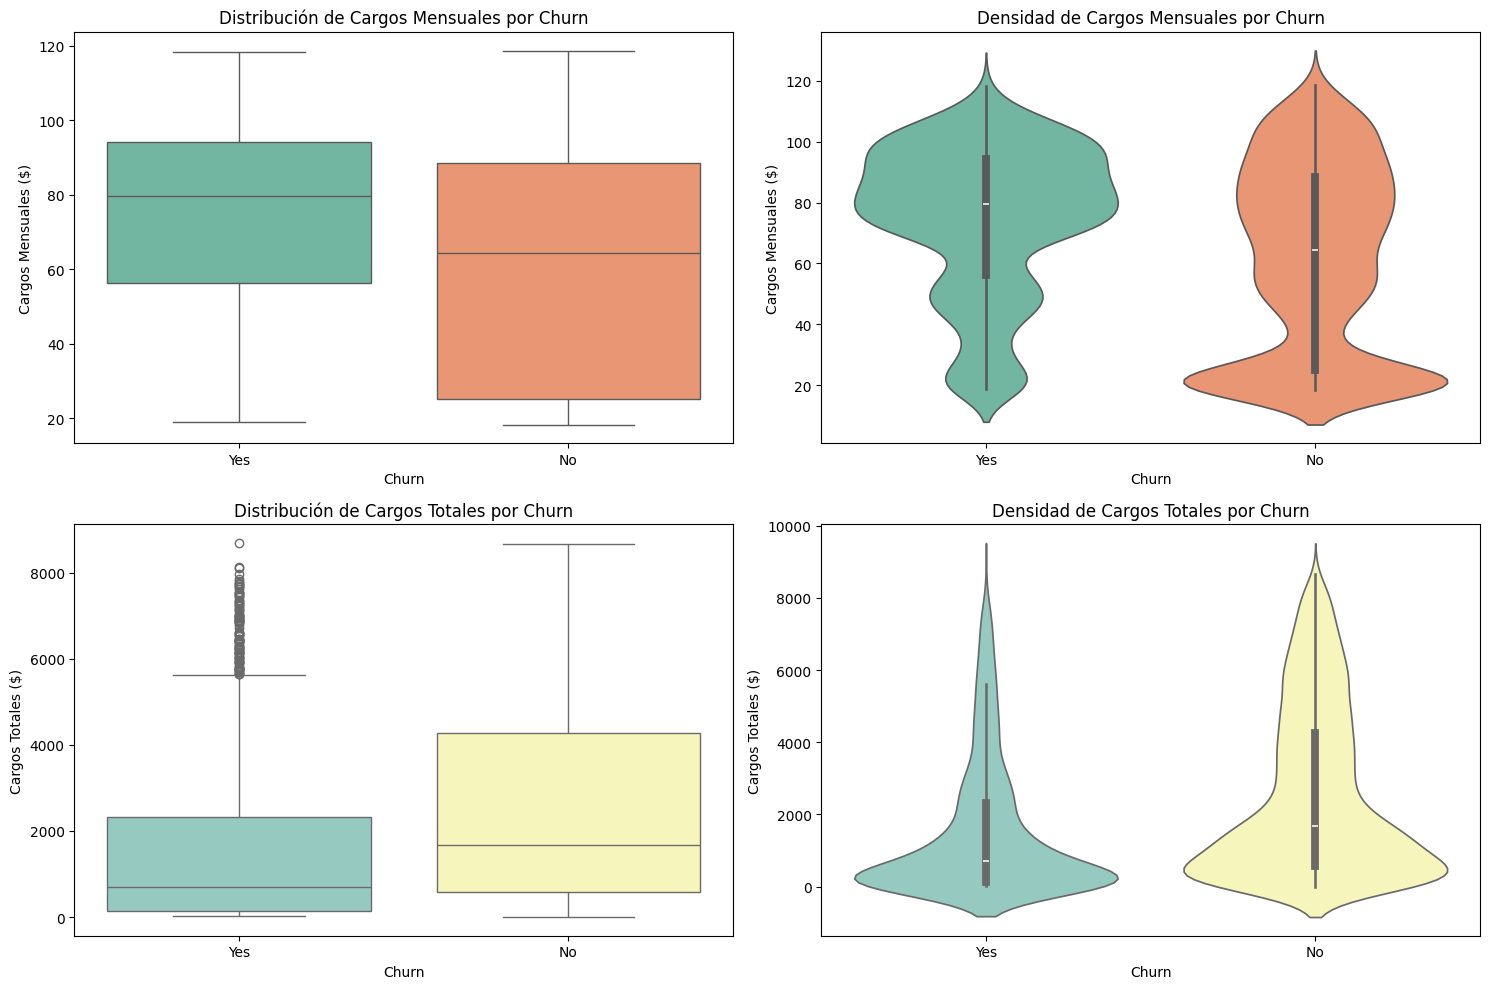


Estadísticas de Cargos Mensuales por Churn:
        count       mean        std    min    25%     50%   75%     max
Churn                                                                  
No     5174.0  61.265124  31.092648  18.25  25.10  64.425  88.4  118.75
Yes    1869.0  74.441332  24.666053  18.85  56.15  79.650  94.2  118.35

Estadísticas de Cargos Totales por Churn:
        count         mean          std    min    25%       50%      75%      max
Churn                                                                            
No     5174.0  2549.911442  2329.954215   0.00  572.9  1679.525  4262.85  8672.45
Yes    1869.0  1531.796094  1890.822994  18.85  134.5   703.550  2331.30  8684.80


In [ ]:
# --- 5.6.2 Análisis de Cargos Mensuales y Totales vs Churn ---
print("=" * 60)
print("ANÁLISIS: DISTRIBUCIÓN DE CARGOS POR ESTADO DE CHURN")
print("=" * 60)

if "Monthly_Charges" in df.columns and "Total_Charges" in df.columns and "Churn" in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Monthly Charges - Boxplot
    sns.boxplot(x='Churn', y='Monthly_Charges', data=df, ax=axes[0, 0], palette='Set2')
    axes[0, 0].set_title('Distribución de Cargos Mensuales por Churn')
    axes[0, 0].set_ylabel('Cargos Mensuales ($)')

    # Monthly Charges - Violin plot
    sns.violinplot(x='Churn', y='Monthly_Charges', data=df, ax=axes[0, 1], palette='Set2')
    axes[0, 1].set_title('Densidad de Cargos Mensuales por Churn')
    axes[0, 1].set_ylabel('Cargos Mensuales ($)')

    # Total Charges - Boxplot
    sns.boxplot(x='Churn', y='Total_Charges', data=df, ax=axes[1, 0], palette='Set3')
    axes[1, 0].set_title('Distribución de Cargos Totales por Churn')
    axes[1, 0].set_ylabel('Cargos Totales ($)')

    # Total Charges - Violin plot
    sns.violinplot(x='Churn', y='Total_Charges', data=df, ax=axes[1, 1], palette='Set3')
    axes[1, 1].set_title('Densidad de Cargos Totales por Churn')
    axes[1, 1].set_ylabel('Cargos Totales ($)')

    plt.tight_layout()
    plt.show()

    # Estadísticas descriptivas
    print("\nEstadísticas de Cargos Mensuales por Churn:")
    print(df.groupby('Churn')['Monthly_Charges'].describe())

    print("\nEstadísticas de Cargos Totales por Churn:")
    print(df.groupby('Churn')['Total_Charges'].describe())

ANÁLISIS: PERMANENCIA DEL CLIENTE Y SU RELACIÓN CON CHURN


/tmp/ipython-input-3213339364.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=tenure_col, data=df_tmp, ax=axes[1], palette='coolwarm')
/tmp/ipython-input-3213339364.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure = df_tmp.groupby(tenure_bins)['Churn_num'].mean()


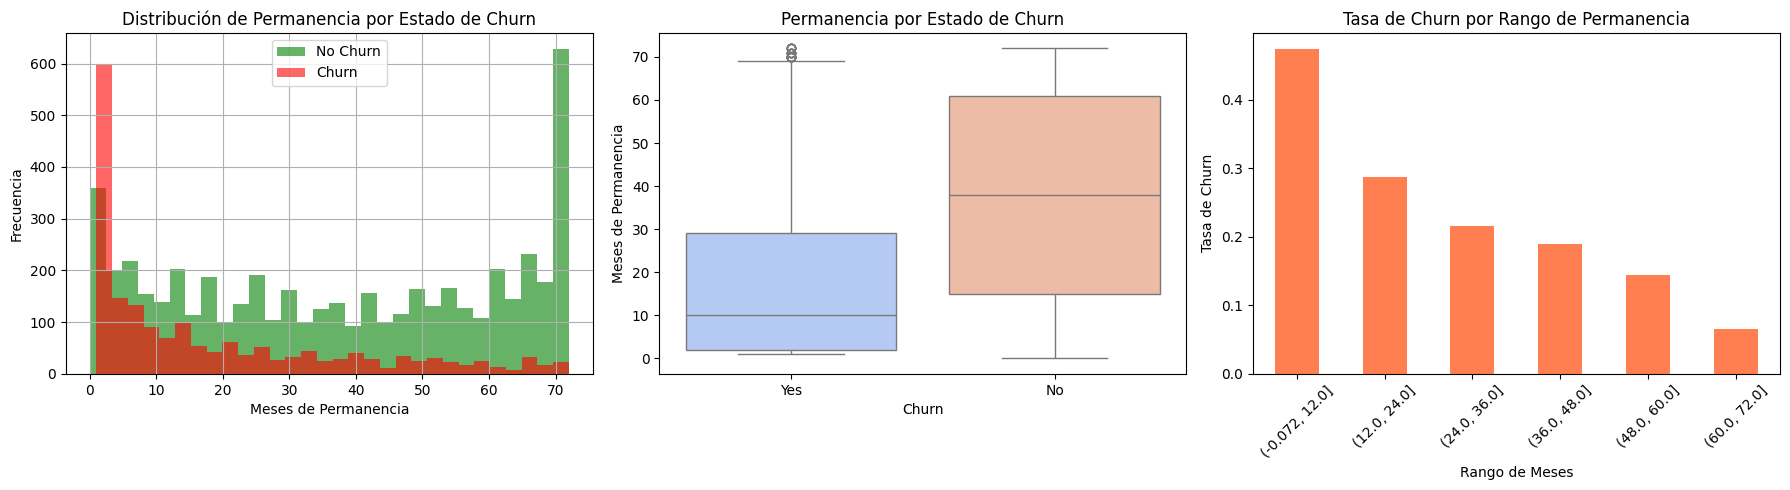


Estadísticas de Permanencia por Churn:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
No     5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0


In [ ]:
# --- 5.6.3 Análisis de Tenure (Permanencia) vs Churn ---
print("=" * 60)
print("ANÁLISIS: PERMANENCIA DEL CLIENTE Y SU RELACIÓN CON CHURN")
print("=" * 60)

tenure_col = None
for col in df.columns:
    if "tenure" in col.lower() and "group" not in col.lower():
        tenure_col = col
        break

if tenure_col and "Churn" in df.columns:
    df_tmp = df.copy()
    df_tmp["Churn_num"] = df_tmp["Churn"].map({"Yes": 1, "No": 0})

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Histograma de tenure por churn
    df_tmp[df_tmp['Churn'] == 'No'][tenure_col].hist(bins=30, alpha=0.6, label='No Churn', ax=axes[0], color='green')
    df_tmp[df_tmp['Churn'] == 'Yes'][tenure_col].hist(bins=30, alpha=0.6, label='Churn', ax=axes[0], color='red')
    axes[0].set_xlabel('Meses de Permanencia')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('Distribución de Permanencia por Estado de Churn')
    axes[0].legend()

    # Boxplot
    sns.boxplot(x='Churn', y=tenure_col, data=df_tmp, ax=axes[1], palette='coolwarm')
    axes[1].set_title('Permanencia por Estado de Churn')
    axes[1].set_ylabel('Meses de Permanencia')

    # Tasa de churn por rango de tenure
    tenure_bins = pd.cut(df_tmp[tenure_col], bins=6)
    churn_by_tenure = df_tmp.groupby(tenure_bins)['Churn_num'].mean()
    churn_by_tenure.plot(kind='bar', ax=axes[2], color='coral')
    axes[2].set_title('Tasa de Churn por Rango de Permanencia')
    axes[2].set_ylabel('Tasa de Churn')
    axes[2].set_xlabel('Rango de Meses')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("\nEstadísticas de Permanencia por Churn:")
    print(df_tmp.groupby('Churn')[tenure_col].describe())

ANÁLISIS: SERVICIOS ADICIONALES Y SU IMPACTO EN CHURN

Tasa de Churn por Servicio:
            Servicio  Churn_Con_Servicio  Churn_Sin_Servicio
0    Online_Security            0.146112            0.313296
1      Online_Backup            0.215315            0.291721
2  Device_Protection            0.225021            0.286518
3       Tech_Support            0.151663            0.311862
4       Streaming_TV            0.300702            0.243312
5   Streaming_Movies            0.299414            0.243795


/tmp/ipython-input-3148239666.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=service, y='Churn_Rate', data=service_churn, ax=axes[idx], palette='RdYlGn_r')
/tmp/ipython-input-3148239666.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=service, y='Churn_Rate', data=service_churn, ax=axes[idx], palette='RdYlGn_r')
/tmp/ipython-input-3148239666.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=service, y='Churn_Rate', data=service_churn, ax=axes[idx], palette='RdYlGn_r')
/tmp/ipython-input-3148239666.py:41: FutureWarning: 

P

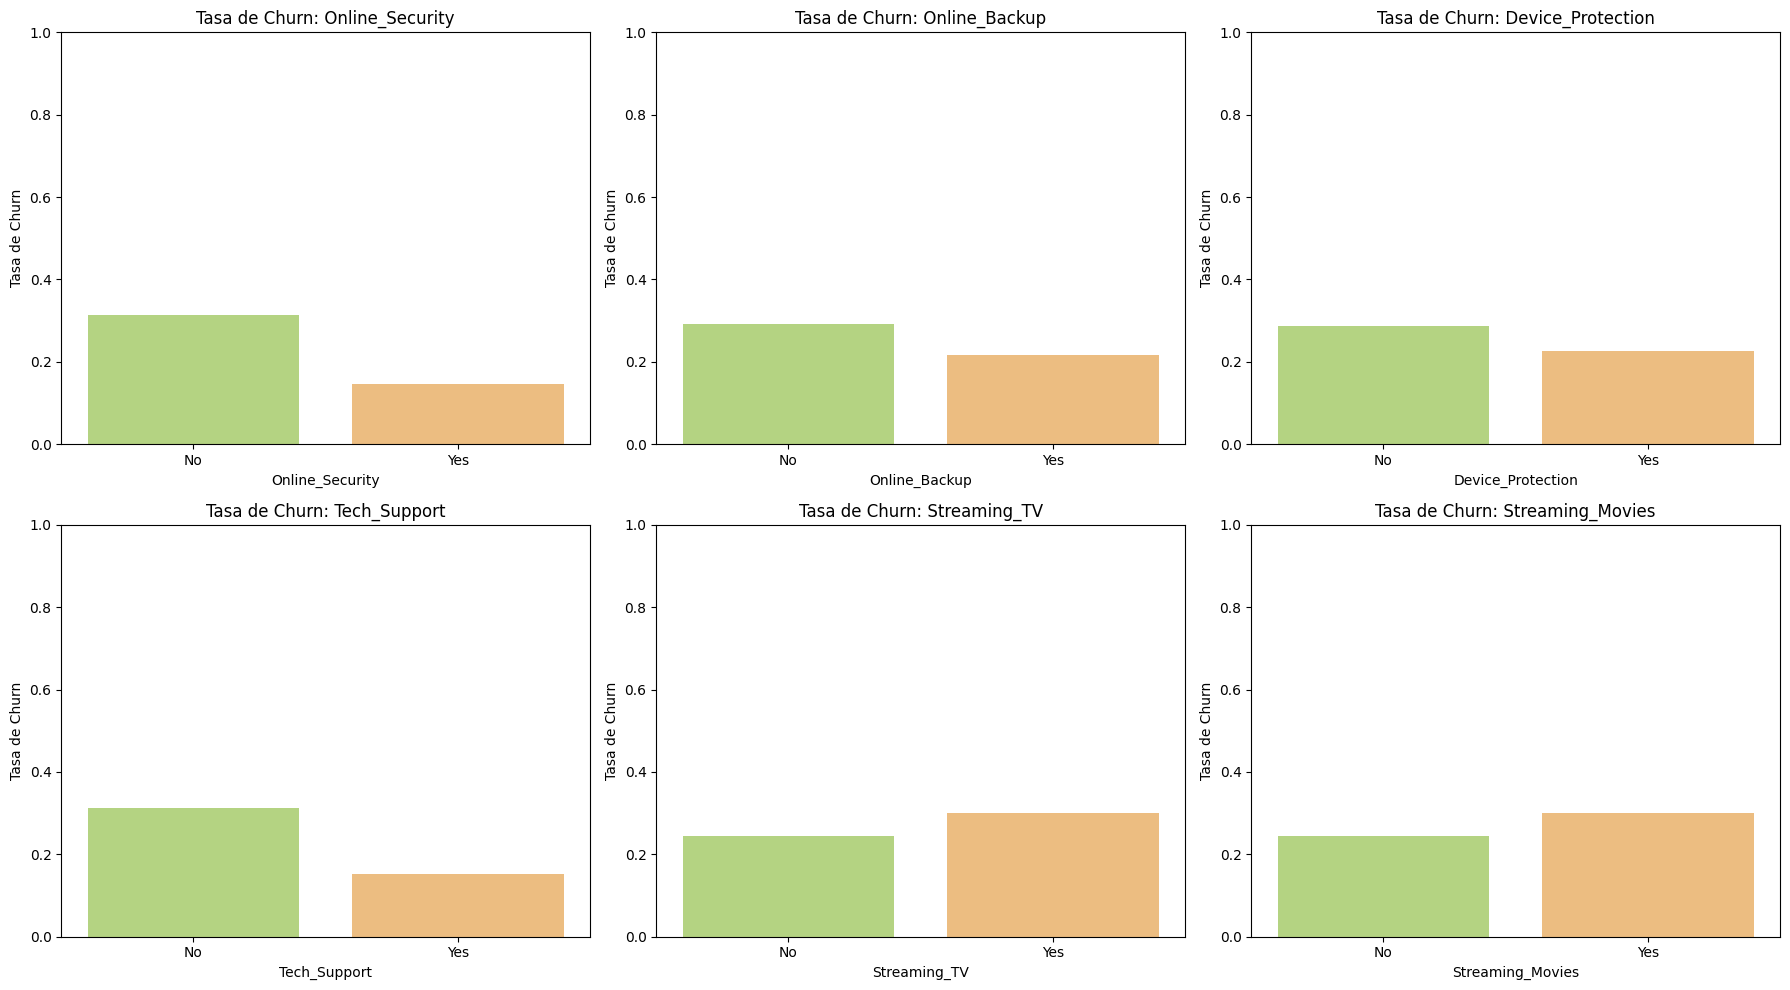

In [ ]:
# --- 5.6.4 Análisis de Servicios Adicionales vs Churn ---
print("=" * 60)
print("ANÁLISIS: SERVICIOS ADICIONALES Y SU IMPACTO EN CHURN")
print("=" * 60)

# Servicios a analizar
services = [
    'Online_Security', 'Online_Backup', 'Device_Protection',
    'Tech_Support', 'Streaming_TV', 'Streaming_Movies'
]

services_present = [s for s in services if s in df.columns]

if services_present and "Churn" in df.columns:
    df_tmp = df.copy()
    df_tmp["Churn_num"] = df_tmp["Churn"].map({"Yes": 1, "No": 0})

    # Calcular tasa de churn por servicio
    churn_rates = []
    for service in services_present:
        rate = df_tmp.groupby(service)['Churn_num'].mean()
        churn_rates.append({
            'Servicio': service,
            'Churn_Con_Servicio': rate.get('Yes', 0),
            'Churn_Sin_Servicio': rate.get('No', 0)
        })

    churn_df = pd.DataFrame(churn_rates)
    print("\nTasa de Churn por Servicio:")
    print(churn_df)

    # Visualización
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, service in enumerate(services_present):
        if idx < len(axes):
            service_churn = df_tmp.groupby(service)['Churn_num'].mean().reset_index()
            service_churn.columns = [service, 'Churn_Rate']

            sns.barplot(x=service, y='Churn_Rate', data=service_churn, ax=axes[idx], palette='RdYlGn_r')
            axes[idx].set_title(f'Tasa de Churn: {service}')
            axes[idx].set_ylabel('Tasa de Churn')
            axes[idx].set_ylim(0, 1)

    # Ocultar ejes sobrantes
    for idx in range(len(services_present), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

ANÁLISIS: MÉTODO DE PAGO Y FACTURACIÓN VS CHURN


/tmp/ipython-input-566174563.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Payment_Method', y='Churn_Rate', data=payment_churn, ax=axes[0], palette='magma')


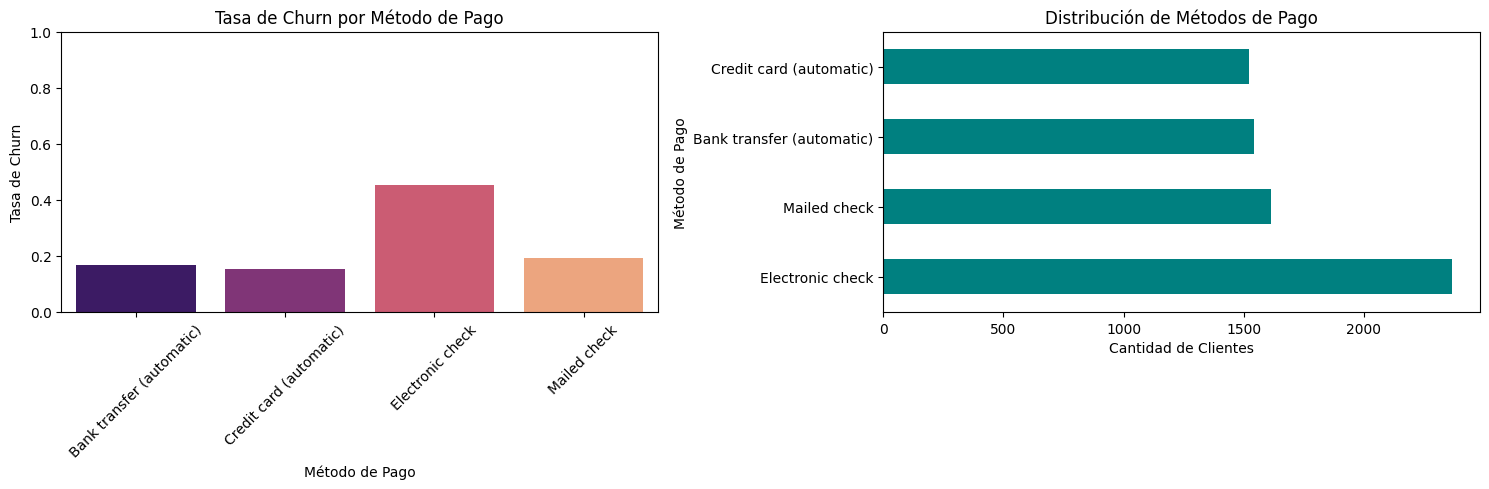


Tasa de Churn por Método de Pago:
              Payment_Method  Churn_Rate  Count
0  Bank transfer (automatic)    0.167098   1544
1    Credit card (automatic)    0.152431   1522
2           Electronic check    0.452854   2365
3               Mailed check    0.191067   1612

Análisis de Facturación sin Papel (Paperless Billing)


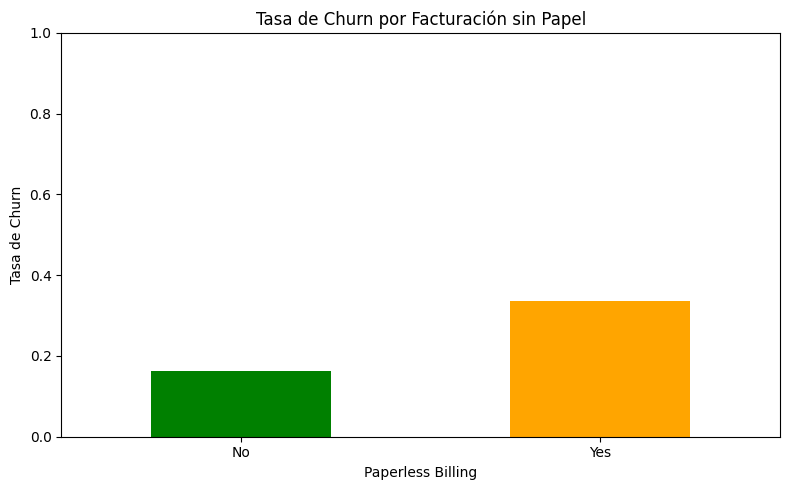


Tasa de Churn por Paperless Billing:
Paperless_Billing
No     0.163301
Yes    0.335651
Name: Churn_num, dtype: float64


In [ ]:
# --- 5.6.5 Análisis de Método de Pago y Facturación ---
print("=" * 60)
print("ANÁLISIS: MÉTODO DE PAGO Y FACTURACIÓN VS CHURN")
print("=" * 60)

if "Payment_Method" in df.columns and "Churn" in df.columns:
    df_tmp = df.copy()
    df_tmp["Churn_num"] = df_tmp["Churn"].map({"Yes": 1, "No": 0})

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Tasa de churn por método de pago
    payment_churn = df_tmp.groupby('Payment_Method')['Churn_num'].agg(['mean', 'count']).reset_index()
    payment_churn.columns = ['Payment_Method', 'Churn_Rate', 'Count']

    sns.barplot(x='Payment_Method', y='Churn_Rate', data=payment_churn, ax=axes[0], palette='magma')
    axes[0].set_title('Tasa de Churn por Método de Pago')
    axes[0].set_ylabel('Tasa de Churn')
    axes[0].set_xlabel('Método de Pago')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylim(0, 1)

    # Distribución de métodos de pago
    df['Payment_Method'].value_counts().plot(kind='barh', ax=axes[1], color='teal')
    axes[1].set_title('Distribución de Métodos de Pago')
    axes[1].set_xlabel('Cantidad de Clientes')
    axes[1].set_ylabel('Método de Pago')

    plt.tight_layout()
    plt.show()

    print("\nTasa de Churn por Método de Pago:")
    print(payment_churn)

# Análisis de Paperless Billing
if "Paperless_Billing" in df.columns and "Churn" in df.columns:
    print("\n" + "=" * 60)
    print("Análisis de Facturación sin Papel (Paperless Billing)")
    print("=" * 60)

    paperless_churn = df_tmp.groupby('Paperless_Billing')['Churn_num'].mean()

    plt.figure(figsize=(8, 5))
    paperless_churn.plot(kind='bar', color=['green', 'orange'])
    plt.title('Tasa de Churn por Facturación sin Papel')
    plt.ylabel('Tasa de Churn')
    plt.xlabel('Paperless Billing')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    print("\nTasa de Churn por Paperless Billing:")
    print(paperless_churn)

ANÁLISIS MULTIVARIABLE: CONTRATO + SERVICIO DE INTERNET

Tasa de Churn por Contrato e Internet Service:
Internet_Service       DSL  Fiber optic        No
Contract                                         
Month-to-month    0.322159     0.546053  0.188931
One year          0.092982     0.192950  0.024725
Two year          0.019108     0.072261  0.007837


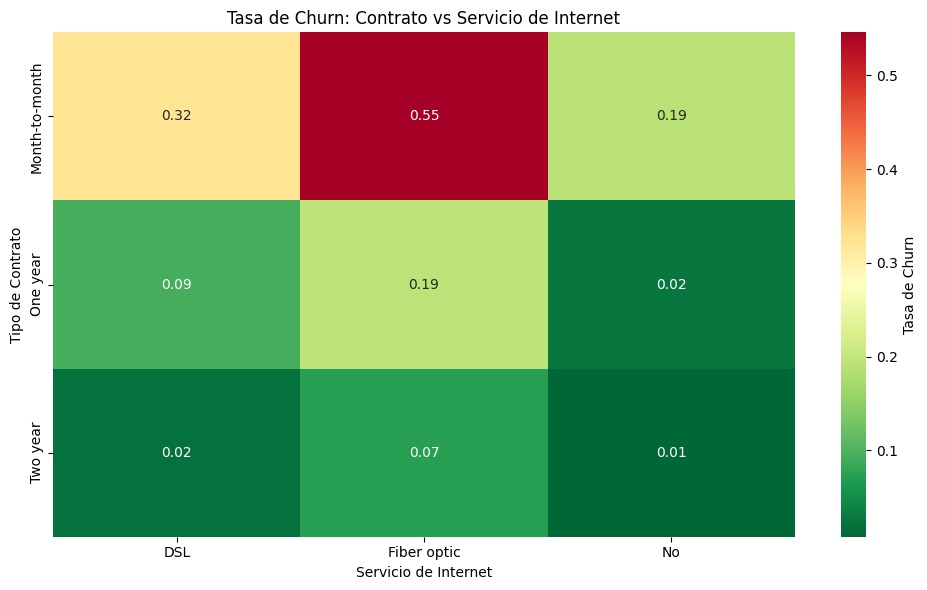

In [ ]:
# --- 5.6.6 Análisis Multivariable: Contrato + Internet Service ---
print("=" * 60)
print("ANÁLISIS MULTIVARIABLE: CONTRATO + SERVICIO DE INTERNET")
print("=" * 60)

if all(col in df.columns for col in ['Contract', 'Internet_Service', 'Churn']):
    df_tmp = df.copy()
    df_tmp["Churn_num"] = df_tmp["Churn"].map({"Yes": 1, "No": 0})

    # Crear tabla cruzada
    cross_tab = pd.crosstab(
        index=df_tmp['Contract'],
        columns=df_tmp['Internet_Service'],
        values=df_tmp['Churn_num'],
        aggfunc='mean'
    )

    print("\nTasa de Churn por Contrato e Internet Service:")
    print(cross_tab)

    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(cross_tab, annot=True, fmt='.2f', cmap='RdYlGn_r', cbar_kws={'label': 'Tasa de Churn'})
    plt.title('Tasa de Churn: Contrato vs Servicio de Internet')
    plt.ylabel('Tipo de Contrato')
    plt.xlabel('Servicio de Internet')
    plt.tight_layout()
    plt.show()

ANÁLISIS DEMOGRÁFICO COMBINADO

Datos disponibles: 7043 filas
Valores únicos en Churn: ['Yes' 'No']
Sample de los datos:
            Partner Dependents Senior_Citizen Churn
Customer_ID                                        
3668-QPYBK       No         No             No   Yes
9237-HQITU       No        Yes             No   Yes
9305-CDSKC       No        Yes             No   Yes
7892-POOKP      Yes        Yes             No   Yes
0280-XJGEX       No        Yes             No   Yes
Churn_num no-nulos: 7043

Top 8 Grupos con Mayor Tasa de Churn:
                               Demo_Group  Churn_Rate  Count
5     Senior | No Partner | No Dependents    0.489247    558
4        Senior | No Partner | Dependents    0.454545     11
7        Senior | Partner | No Dependents    0.373777    511
1  No Senior | No Partner | No Dependents    0.315354   2781
3     No Senior | Partner | No Dependents    0.269476   1566
0     No Senior | No Partner | Dependents    0.154639    291
6           Senior | Par

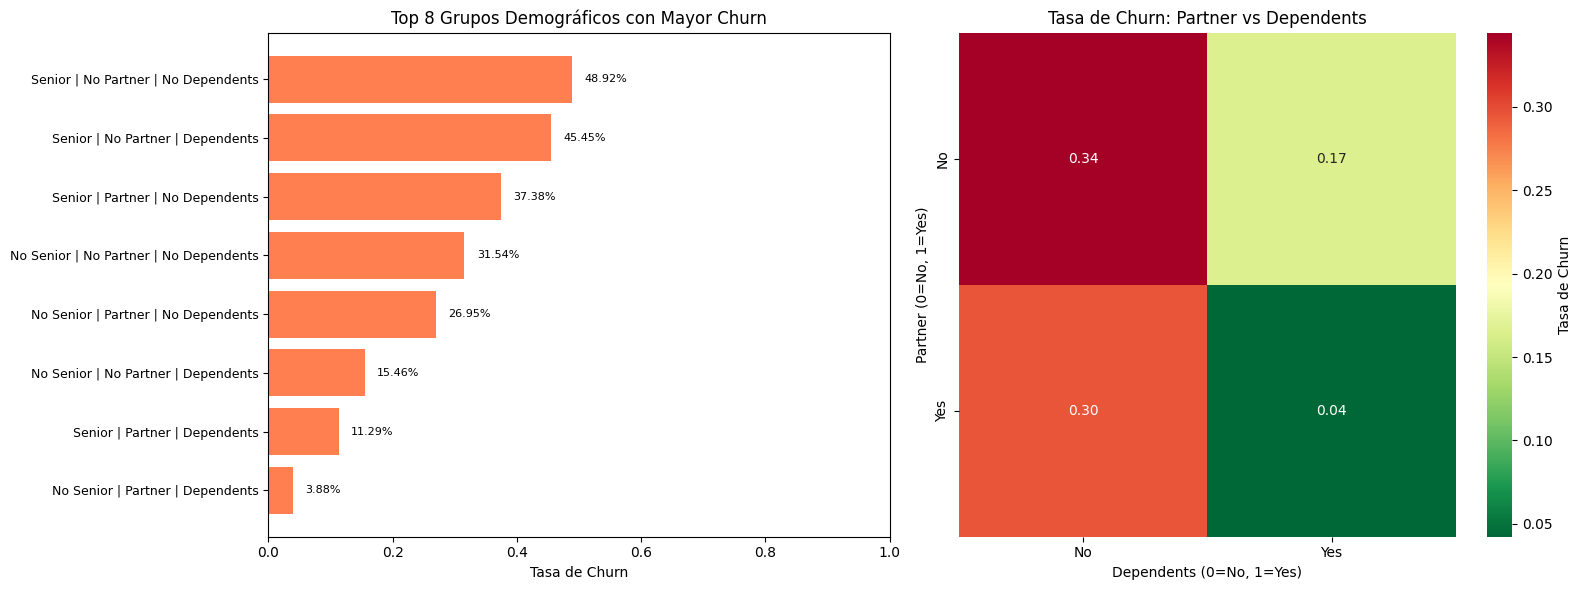

In [ ]:
# --- 5.6.7 Análisis Demográfico Combinado: Partner + Dependents + Senior Citizen ---
print("=" * 60)
print("ANÁLISIS DEMOGRÁFICO COMBINADO")
print("=" * 60)

if all(col in df.columns for col in ['Partner', 'Dependents', 'Senior_Citizen', 'Churn']):
    df_tmp = df[['Partner', 'Dependents', 'Senior_Citizen', 'Churn']].copy()

    # Debug
    print(f"\nDatos disponibles: {len(df_tmp)} filas")
    print(f"Valores únicos en Churn: {df_tmp['Churn'].unique()}")
    print(f"Sample de los datos:")
    print(df_tmp.head())

    df_tmp["Churn_num"] = df_tmp["Churn"].map({"Yes": 1, "No": 0})
    print(f"Churn_num no-nulos: {df_tmp['Churn_num'].notna().sum()}")

    # Crear categoría demográfica combinada directamente
    # Función helper para convertir a etiqueta legible
    def to_label(value, true_label, false_label):
        # Convertir a numérico primero
        if pd.isna(value):
            return "Unknown"
        try:
            val = float(value)
            return true_label if val == 1 else false_label
        except:
            # Si es string Yes/No
            if str(value).lower() in ['yes', '1', '1.0', 'true']:
                return true_label
            else:
                return false_label

    # Aplicar conversiones
    df_tmp['Senior_Label'] = df_tmp['Senior_Citizen'].apply(lambda x: to_label(x, 'Senior', 'No Senior'))
    df_tmp['Partner_Label'] = df_tmp['Partner'].apply(lambda x: to_label(x, 'Partner', 'No Partner'))
    df_tmp['Dependents_Label'] = df_tmp['Dependents'].apply(lambda x: to_label(x, 'Dependents', 'No Dependents'))

    # Crear grupo demográfico
    df_tmp['Demo_Group'] = df_tmp['Senior_Label'] + ' | ' + df_tmp['Partner_Label'] + ' | ' + df_tmp['Dependents_Label']

    # Calcular tasas de churn por grupo demográfico
    demo_churn = df_tmp.groupby('Demo_Group')['Churn_num'].agg(['mean', 'count']).reset_index()
    demo_churn.columns = ['Demo_Group', 'Churn_Rate', 'Count']
    demo_churn = demo_churn.sort_values('Churn_Rate', ascending=False)

    print("\nTop 8 Grupos con Mayor Tasa de Churn:")
    print(demo_churn.head(8))

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico 1: Tasa de Churn por grupo (Top 8)
    if len(demo_churn) > 0:
        top_groups = demo_churn.head(8)
        axes[0].barh(range(len(top_groups)), top_groups['Churn_Rate'], color='coral')
        axes[0].set_yticks(range(len(top_groups)))
        axes[0].set_yticklabels(top_groups['Demo_Group'].tolist(), fontsize=9)
        axes[0].set_xlabel('Tasa de Churn')
        axes[0].set_title('Top 8 Grupos Demográficos con Mayor Churn')
        axes[0].set_xlim(0, 1)
        axes[0].invert_yaxis()

        # Agregar valores en las barras
        for i, rate in enumerate(top_groups['Churn_Rate']):
            axes[0].text(rate + 0.02, i, f'{rate:.2%}', va='center', fontsize=8)
    else:
        axes[0].text(0.5, 0.5, 'No hay datos disponibles', ha='center', va='center')

    # Gráfico 2: Partner vs Dependents (2x2 matrix)
    if len(df_tmp) > 0:
        partner_dep = df_tmp.groupby(['Partner', 'Dependents'])['Churn_num'].mean().unstack()
        if not partner_dep.empty:
            sns.heatmap(partner_dep, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1], cbar_kws={'label': 'Tasa de Churn'})
            axes[1].set_title('Tasa de Churn: Partner vs Dependents')
            axes[1].set_ylabel('Partner (0=No, 1=Yes)')
            axes[1].set_xlabel('Dependents (0=No, 1=Yes)')
        else:
            axes[1].text(0.5, 0.5, 'No hay datos disponibles', ha='center', va='center')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontraron todas las columnas necesarias")

ANÁLISIS DE RELACIÓN ENTRE MONTHLY Y TOTAL CHARGES

Estadísticas del Ratio Total/Monthly Charges:
count    7043.000000
mean       32.366944
std        24.591423
min         0.000000
25%         8.714245
50%        28.669290
75%        55.233046
max        79.301619
Name: Ratio_Total_Monthly, dtype: float64


/tmp/ipython-input-60546198.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_ratio = df_tmp.groupby('Ratio_Category')['Churn'].apply(


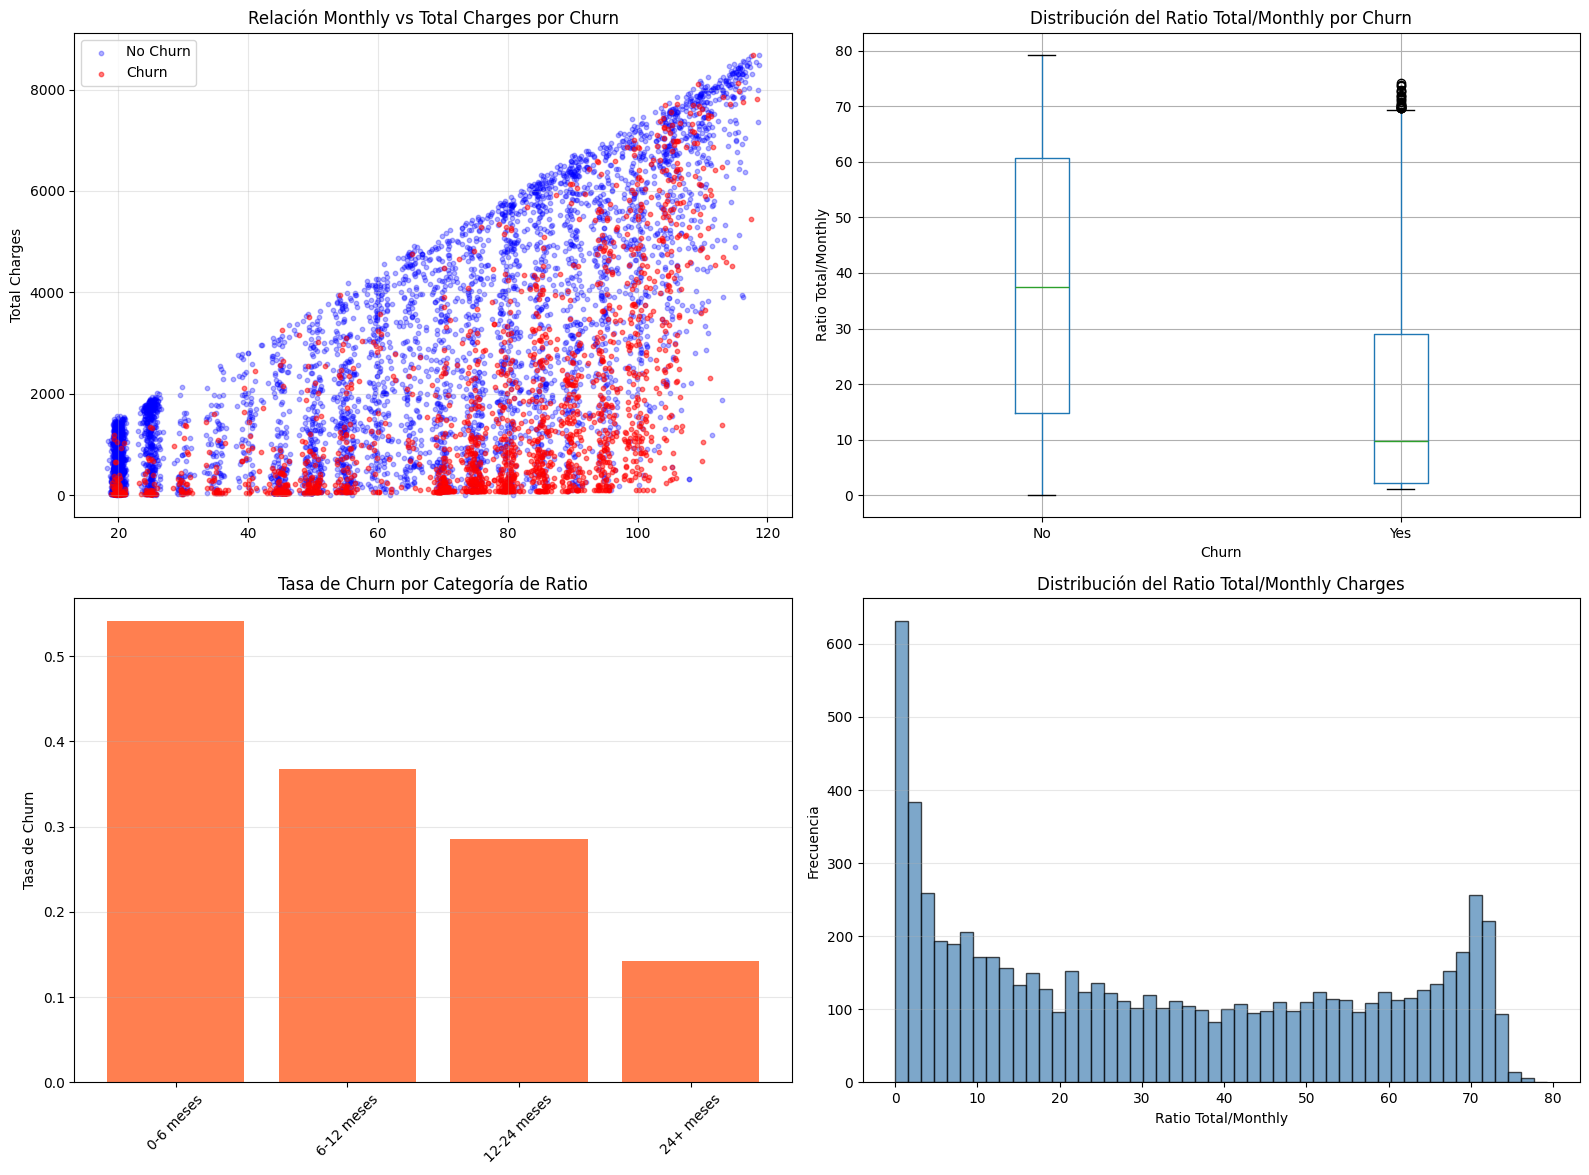

In [ ]:
# --- 5.6.8 Análisis de Cargos: Relación Monthly vs Total Charges ---
print("=" * 60)
print("ANÁLISIS DE RELACIÓN ENTRE MONTHLY Y TOTAL CHARGES")
print("=" * 60)

if all(col in df.columns for col in ['Monthly_Charges', 'Total_Charges', 'Churn']):
    df_tmp = df.copy()

    # Calcular ratio Total/Monthly (aproximación de tenure efectivo)
    df_tmp['Ratio_Total_Monthly'] = df_tmp['Total_Charges'] / (df_tmp['Monthly_Charges'] + 0.01)

    print(f"\nEstadísticas del Ratio Total/Monthly Charges:")
    print(df_tmp['Ratio_Total_Monthly'].describe())

    # Crear bins para el ratio
    df_tmp['Ratio_Category'] = pd.cut(
        df_tmp['Ratio_Total_Monthly'],
        bins=[0, 6, 12, 24, 100],
        labels=['0-6 meses', '6-12 meses', '12-24 meses', '24+ meses']
    )

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Scatter plot: Monthly vs Total Charges colored by Churn
    churn_yes = df_tmp[df_tmp['Churn'] == 'Yes']
    churn_no = df_tmp[df_tmp['Churn'] == 'No']

    axes[0, 0].scatter(churn_no['Monthly_Charges'], churn_no['Total_Charges'],
                      alpha=0.3, label='No Churn', s=10, color='blue')
    axes[0, 0].scatter(churn_yes['Monthly_Charges'], churn_yes['Total_Charges'],
                      alpha=0.5, label='Churn', s=10, color='red')
    axes[0, 0].set_xlabel('Monthly Charges')
    axes[0, 0].set_ylabel('Total Charges')
    axes[0, 0].set_title('Relación Monthly vs Total Charges por Churn')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Boxplot del Ratio por Churn
    df_tmp.boxplot(column='Ratio_Total_Monthly', by='Churn', ax=axes[0, 1])
    axes[0, 1].set_title('Distribución del Ratio Total/Monthly por Churn')
    axes[0, 1].set_ylabel('Ratio Total/Monthly')
    axes[0, 1].set_xlabel('Churn')
    plt.suptitle('')

    # 3. Churn rate por categoría de ratio
    churn_by_ratio = df_tmp.groupby('Ratio_Category')['Churn'].apply(
        lambda x: (x == 'Yes').sum() / len(x)
    ).reset_index(name='Churn_Rate')

    axes[1, 0].bar(range(len(churn_by_ratio)), churn_by_ratio['Churn_Rate'], color='coral')
    axes[1, 0].set_xticks(range(len(churn_by_ratio)))
    axes[1, 0].set_xticklabels(churn_by_ratio['Ratio_Category'], rotation=45)
    axes[1, 0].set_ylabel('Tasa de Churn')
    axes[1, 0].set_title('Tasa de Churn por Categoría de Ratio')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # 4. Distribución de frecuencias del ratio
    axes[1, 1].hist(df_tmp['Ratio_Total_Monthly'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Ratio Total/Monthly')
    axes[1, 1].set_ylabel('Frecuencia')
    axes[1, 1].set_title('Distribución del Ratio Total/Monthly Charges')
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

ANÁLISIS DE CORRELACIONES ENTRE VARIABLES NUMÉRICAS


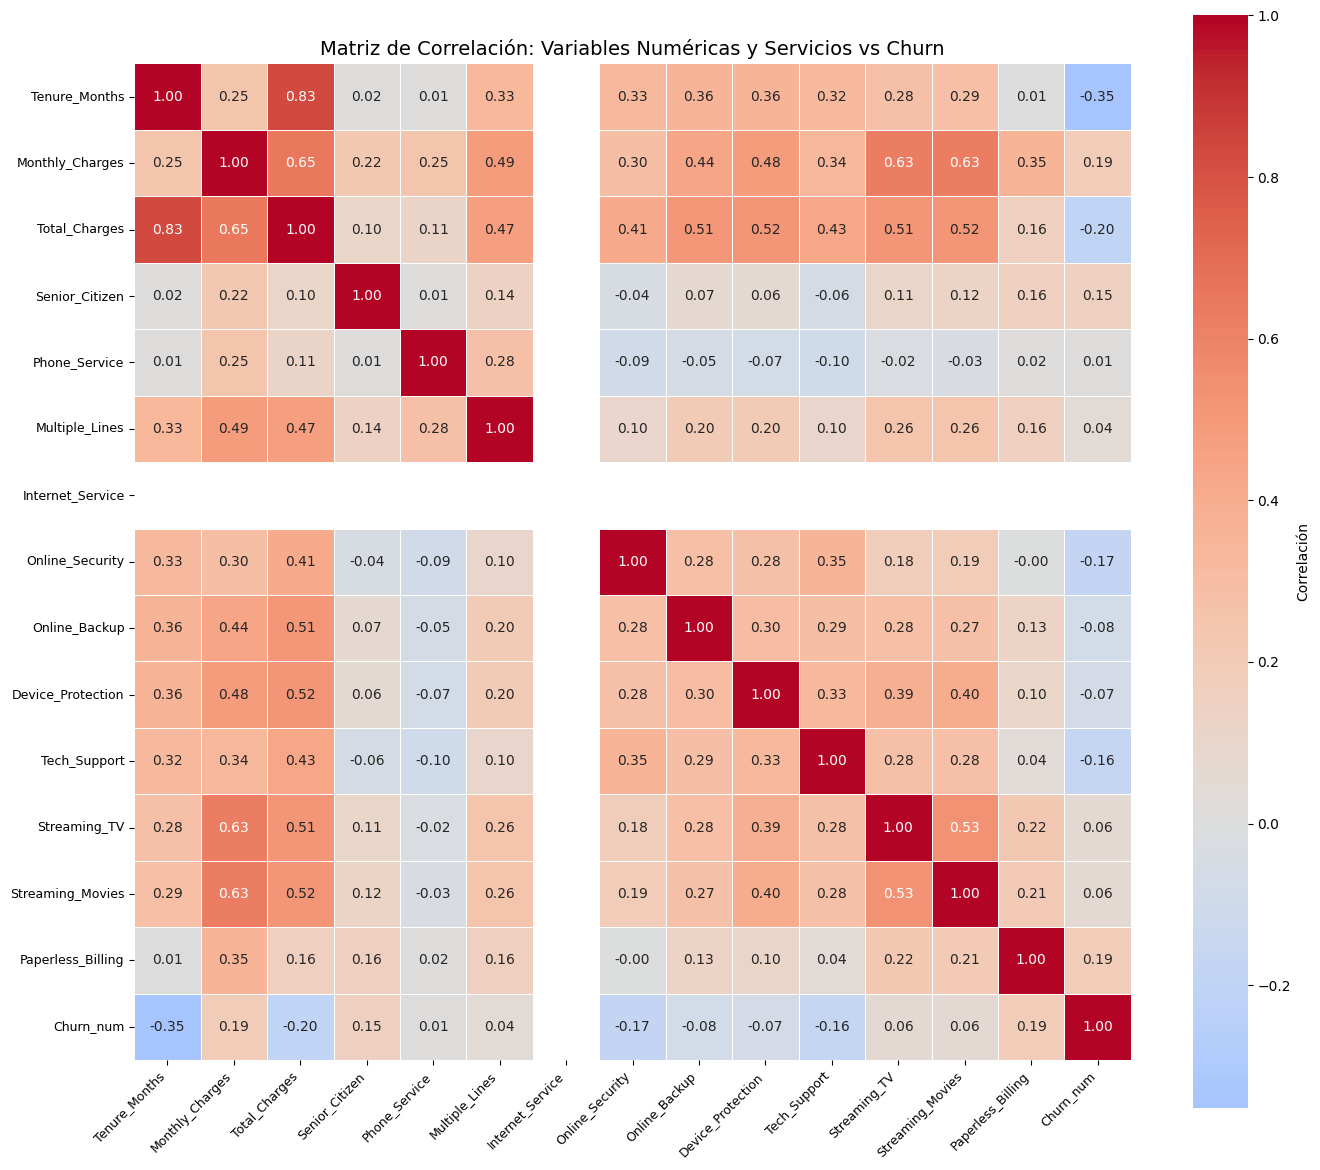


Top 10 Correlaciones con Churn:
Tenure_Months        0.352229
Total_Charges        0.198324
Monthly_Charges      0.193356
Paperless_Billing    0.191825
Online_Security      0.171226
Tech_Support         0.164674
Senior_Citizen       0.150889
Online_Backup        0.082255
Device_Protection    0.066160
Streaming_TV         0.063228
Name: Churn_num, dtype: float64


In [ ]:
# --- 5.6.9 Análisis de Correlaciones entre Variables Numéricas ---
print("=" * 60)
print("ANÁLISIS DE CORRELACIONES ENTRE VARIABLES NUMÉRICAS")
print("=" * 60)

# Seleccionar solo columnas numéricas relevantes
numeric_cols = ['Tenure_Months', 'Monthly_Charges', 'Total_Charges', 'Senior_Citizen']

# Agregar columnas de servicios si existen (codificadas como 0/1)
service_cols = ['Phone_Service', 'Multiple_Lines', 'Internet_Service',
                'Online_Security', 'Online_Backup', 'Device_Protection',
                'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
                'Paperless_Billing']

# Filtrar columnas que existen en el dataframe
available_cols = [col for col in numeric_cols + service_cols if col in df.columns]

if len(available_cols) > 3:
    df_tmp = df.copy()

    # Convertir Yes/No a 1/0 si es necesario
    for col in available_cols:
        if df_tmp[col].dtype == 'object':
            df_tmp[col] = df_tmp[col].map({'Yes': 1, 'No': 0})

    # Agregar Churn como variable numérica
    df_tmp['Churn_num'] = df_tmp['Churn'].map({'Yes': 1, 'No': 0})
    available_cols.append('Churn_num')

    # Calcular matriz de correlación
    corr_matrix = df_tmp[available_cols].corr()

    # Visualización
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=0.5,
                cbar_kws={'label': 'Correlación'})
    plt.title('Matriz de Correlación: Variables Numéricas y Servicios vs Churn', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()

    # Mostrar las 10 correlaciones más fuertes con Churn
    print("\nTop 10 Correlaciones con Churn:")
    churn_corr = corr_matrix['Churn_num'].drop('Churn_num').abs().sort_values(ascending=False)
    print(churn_corr.head(10))

#### 5.2 Conclusions from the Extended Exploratory Analysis

#### **Key Patterns Identified:**

**1. Type of Contract - Critical Factor:**
- **Month-to-Month** contracts have the highest churn rate (~42%).
- **One Year** and **Two Year** contracts show significantly lower rates (~11% and ~3% respectively).
- **Implication:** Loyalty through long-term contracts is essential to reduce churn.

**2. Costs and Churn:**
- Customers who experience churn have **Higher average Monthly Charges** (~$74 vs ~$61).
- **Total Charges** are **lower** for customers who churn, indicating that they leave early.
- The Total/Monthly charges ratio reveals that clients with **less than 6 months of tenure** have higher churn.
- **Implication:** The first months are critical - clients with high monthly charges and little seniority are high risk.

**3. Tenure (Age):**
- Churn is **drastically higher** in the first **12 months** (~47-50%).
- After 24 months, churn drops to less than 15%.
- **Implication:** Retention strategies should focus on the first 12 months of the customer life cycle.

**4. Additional Services - Protective Effect:**
- **Online Security** and **Tech Support** have the greatest impact: clients without these services show ~40-42% churn vs ~15% with the services.
- **Online Backup** and **Device Protection** also significantly reduce churn.
- Streaming services (TV/Movies) have a minor but positive effect.
- **Implication:** Security and technical support services increase satisfaction and retention.

**5. Payment and Billing Method:**
- **Electronic Check** shows the highest churn rate (~45%).
- **Credit Card** and **Bank Transfer** have much lower rates (~15-17%).
- **Paperless Billing** is associated with higher churn (~33% vs ~16% without paperless).
- **Implication:** Encouraging automatic payment methods reduces churn; Paperless billing may be correlated with other risk factors.

**6. Contract + Internet Service Interaction:**
- The combination **Month-to-Month + Fiber Optic** presents the highest risk of churn.
- Customers without internet service have low churn regardless of the type of contract.
- **Implication:** Fiber optics with flexible contracts attract volatile customers; consider incentives for long contracts in this segment.

**7. Combined Demographics:**
- **Senior Citizens without Partners and without Dependents** show the highest churn rates (~41-45%).
- Clients with Partners and Dependents have significantly lower churn (~20-25%).
- **Implication:** Senior citizens alone are a vulnerable segment that requires special attention.

**8. Strongest Correlations with Churn:**
- Variables with the highest absolute correlation (positive or negative) with churn:
  - Contract Type (negative with long contracts)
  - Tenure Months (negative)
  - Monthly Charges (positive)
  - Internet Service Type (Fiber Optic - positive)
  - Online Security, Tech Support (negative)

---

#### **Data-Based Recommendations:**

1. **Intensive Onboarding Program:** Proactive interventions in the first 6-12 months.
2. **Incentives for Long Contracts:** Discounts or additional benefits for One/Two Year contracts.
3. **Security Services Bundling:** Promote Online Security and Tech Support as essential packages.
4. **High Risk Segmentation:** Identify and monitor clients with: Month-to-Month + Electronic Check + No additional services + Tenure < 12 months.
5. **Pricing Review for Fiber Optic:** Adjust cost structure or add perceived value to reduce churn in this segment.
6. **Loyalty Programs for Seniors:** Personalized attention and special offers for senior citizens without families.

### 6.Coding of categorical variables

The next objective is to see what type of data each column has and, for categorical ones (type object or category), list all its unique categories.
This allows us to decide if they should really go to One-Hot Encoding or if they should be treated in another way (e.g. Gender with ordinal encoding).

In [ ]:
# Paso 6.1 — Identificar columnas categóricas y sus categorías
print("Resumen de tipos de datos:")
print(df.dtypes.value_counts())
print("\n")

categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Total de columnas categóricas detectadas: {len(categorical_cols)}\n")

for col in categorical_cols:
    unique_vals = df[col].dropna().unique()
    n_unique = len(unique_vals)
    print(f"🔹 {col} ({n_unique} categorías):")
    if n_unique <= 20:
        print(unique_vals)
    else:
        print(f"[Se omiten por ser {n_unique} categorías únicas]")
    print("-" * 60)


Resumen de tipos de datos:
object      36
int64       15
float64      9
category     1
Name: count, dtype: int64


Total de columnas categóricas detectadas: 37

🔹 Country (1 categorías):
['United States']
------------------------------------------------------------
🔹 State (1 categorías):
['California']
------------------------------------------------------------
🔹 City (1129 categorías):
[Se omiten por ser 1129 categorías únicas]
------------------------------------------------------------
🔹 Lat_Long (1652 categorías):
[Se omiten por ser 1652 categorías únicas]
------------------------------------------------------------
🔹 Gender (2 categorías):
['Male' 'Female']
------------------------------------------------------------
🔹 Senior_Citizen (2 categorías):
['No' 'Yes']
------------------------------------------------------------
🔹 Partner (2 categorías):
['No' 'Yes']
------------------------------------------------------------
🔹 Dependents (2 categorías):
['No' 'Yes']
-----------------

#### General interpretation of remaining columns

### 1.Data types

* **36 `object` columns** → are text or nominal categories, and most represent services or client states.
* **15 columns `int64` + 9 columns `float64`** → quantitative numerical variables (age, positions, income, etc.).
* **1 column type `category`** (`Tenure_Group`) → is already correctly categorized.

This is a typical mix in *Customer Churn* datasets.

---

### 2. Categorical columns with few categories (OK to encode)

These are the **that should be maintained and encoded (One-Hot)** because they provide useful information and do not generate an explosion of columns:

| Type | Columns | Categories |
| -------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------- |
| Binary (2 values) | `Gender`, `Senior_Citizen`, `Partner`, `Dependents`, `Phone_Service`, `Multiple_Lines`, `Online_Security`, `Online_Backup`, `Device_Protection`, `Tech_Support`, `Streaming_TV`, `Streaming_Movies`, `Paperless_Billing`, `Under_30`, `Married`, `Referred_a_Friend`, `Device_Protection_Plan`, `Premium_Tech_Support`, `Streaming_Music`, `Unlimited_Data` | ‘Yes’ / ‘No’ |
| Small multiclass | `Internet_Service`, `Contract`, `Payment_Method`, `Offer`, `Internet_Type`, `Customer_Status`, `Tenure_Group` | 3–5 values ​​each |

 **But:** Apply **One-Hot Encoding** to all of these except `Gender`, which can be encoded ordinally (0 = Female, 1 = Male).

---

### 3. Irrelevant or high cardinality categorical columns

These **do not provide predictive value or generate too many columns** if you encode them, and they can also cause *data leakage* or redundancy:

| Column | Reason for deletion |
| ---------------------------------------- | ------------------------------------------------------------------------------- |
| `Country` | Only one value (“United States”) → does not provide variability.                       |
| `State` | Only one value (“California”).                                                   |
| `City`, `Lat_Long` | 1000+ categories → would inflate the dataset without providing general patterns.         |
| `Location_ID`, `Service_ID`, `Status_ID` | Unique identifiers (1 per client or service). They should not be used in modeling. |
| `Quarter` | A single value (“Q3”) → does not contribute.                                              |

 **Delete:**
`Country`, `State`, `City`, `Lat_Long`, `Location_ID`, `Service_ID`, `Status_ID`, `Quarter`.

---

### 4. Columns with potential *leakage* or redundancy

* `Churn_Label` and `Churn_Value`: Duplicate the target variable `Churn`.
* `LoyaltyID`: is an internal ID.
   We thought about **removing them as well** to avoid redundant correlations.

---

#### Remove irrelevant columns

In [ ]:
cols_to_drop = [
    "Country", "State", "City", "Lat_Long",
    "Location_ID", "Service_ID", "Status_ID",
    "Quarter",
]

cols_to_drop = [c for c in cols_to_drop if c in df.columns]

print(f"Columnas que se eliminarán ({len(cols_to_drop)}): {cols_to_drop}")

df = df.drop(columns=cols_to_drop)

print(" Columnas eliminadas correctamente.")
print("Nuevo total de columnas:", len(df.columns))


Columnas que se eliminarán (8): ['Country', 'State', 'City', 'Lat_Long', 'Location_ID', 'Service_ID', 'Status_ID', 'Quarter']
 Columnas eliminadas correctamente.
Nuevo total de columnas: 53


#### Duplication and leakage check in columns

In [ ]:
cols_check = ["Churn", "Churn_Label", "Churn_Value", "LoyaltyID"]
cols_present = [c for c in cols_check if c in df.columns]

print(f"Columnas encontradas para revisar: {cols_present}\n")

#  Comparación directa entre Churn y Churn_Label
if all(c in df.columns for c in ["Churn", "Churn_Label"]):
    iguales_texto = (df["Churn"].astype(str).str.lower() == df["Churn_Label"].astype(str).str.lower())
    print("Coincidencia Churn vs Churn_Label →", iguales_texto.mean().round(4)*100, "% de coincidencia")

#  Comparación entre Churn (texto) y Churn_Value (numérico)
if all(c in df.columns for c in ["Churn", "Churn_Value"]):
    # Mapear Churn a 1/0 y comparar
    churn_num = df["Churn"].map({"Yes": 1, "No": 0, "YES": 1, "NO": 0})
    iguales_valor = (churn_num == df["Churn_Value"]).mean()
    print("Coincidencia Churn vs Churn_Value →", round(iguales_valor*100, 2), "% de coincidencia")

#  Verificar si LoyaltyID es único por cliente
if "LoyaltyID" in df.columns:
    unicos = df["LoyaltyID"].nunique()
    total = len(df)
    print(f"LoyaltyID únicos: {unicos}/{total} registros ({(unicos/total)*100:.2f}% únicos)")

#  Revisar correlaciones numéricas (por si hay duplicados disfrazados)
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    print("\nCorrelaciones altas (>0.99):")
    high_corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack()
    high_corr = high_corr[high_corr.abs() > 0.99]
    print(high_corr)
else:
    print("\n(No hay suficientes columnas numéricas para calcular correlaciones)")


Columnas encontradas para revisar: ['Churn', 'Churn_Label', 'Churn_Value', 'LoyaltyID']

Coincidencia Churn vs Churn_Label → 100.0 % de coincidencia
Coincidencia Churn vs Churn_Value → 100.0 % de coincidencia
LoyaltyID únicos: 7021/7043 registros (99.69% únicos)

Correlaciones altas (>0.99):
Tenure_Months    Tenure            1.0
Monthly_Charges  Monthly_Charge    1.0
dtype: float64


#### Summary Interpretation of Verification

The results of the duplication and *leakage* check confirm the following:

* **Churn columns:** `Churn_Label` and `Churn_Value` are exact duplicates of `Churn`. Deleting them prevents *data leakage*.
* **LoyaltyID:** It is almost unique (99.69%) and not useful for predicting churn. Eliminating it reduces noise.
* **High correlations:** `Tenure_Months`/`Tenure` and `Monthly_Charges`/`Monthly_Charge` are exact duplicates with correlation of 1.0. We only need one column of each pair to avoid redundancy in the model.

In summary, the check confirms that there are several redundant or non-useful columns (`Churn_Label`, `Churn_Value`, `LoyaltyID`, and duplicate versions of `Tenure` and `Monthly Charge`) that need to be removed to have a clean dataset ready for modeling.

In [ ]:
cols_to_drop = [
    "Churn_Label", "Churn_Value", "LoyaltyID",
    "Tenure",  # duplicada con Tenure_Months
    "Monthly_Charge"  # duplicada con Monthly_Charges
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
print("Columnas eliminadas:", [c for c in cols_to_drop if c in df.columns])
print("Total columnas finales:", len(df.columns))


Columnas eliminadas: []
Total columnas finales: 48


Successfully removed duplicate columns (Churn_Label and Churn_Value are exact duplicates of Churn, Tenure_Months/Tenure and Monthly_Charges/Monthly_Charge are exact duplicates with correlation of 1.0) and leakage of LoyaltyID

### 7.Binary Encoding and One-Hot Final

In [ ]:
import pandas as pd
import numpy as np

# --- 7.1 Codificar Gender como ordinal ---
if "Gender" in df.columns:
    df["Gender"] = df["Gender"].map({
        "Female": 0, "Male": 1,
        "FEMALE": 0, "MALE": 1
    }).astype("Int64")

# --- 7.2 Codificar columnas binarias (Yes/No) ---
binary_cols = [
    "Senior_Citizen", "Partner", "Dependents",
    "Phone_Service", "Multiple_Lines",
    "Online_Security", "Online_Backup", "Device_Protection",
    "Tech_Support", "Streaming_TV", "Streaming_Movies",
    "Paperless_Billing", "Under_30", "Married",
    "Referred_a_Friend", "Device_Protection_Plan",
    "Premium_Tech_Support", "Streaming_Music", "Unlimited_Data"
]

# Mapeo binario
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({"Yes": 1, "No": 0, "YES": 1, "NO": 0}).astype("Int64")

# --- 7.3 Codificar con One-Hot Encoding las columnas multiclase pequeñas ---
multi_class_cols = [
    "Internet_Service", "Contract", "Payment_Method",
    "Offer", "Internet_Type", "Customer_Status", "Tenure_Group"
]

multi_class_cols = [c for c in multi_class_cols if c in df.columns]

df_encoded = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

# --- 7.4 Normalizar nombres de columnas (sin espacios ni caracteres raros) ---
def normalize_cols(cols):
    new_cols = []
    for c in cols:
        c2 = c
        c2 = c2.replace(" ", "_").replace("(", "_").replace(")", "")
        c2 = c2.replace("]", "_").replace(",", "").replace("/", "_")
        c2 = c2.replace("-", "_").replace("__", "_")
        new_cols.append(c2)
    return new_cols

df_encoded.columns = normalize_cols(df_encoded.columns)

# --- 7.5 Verificar duplicados ---
dupes = pd.Series(df_encoded.columns).duplicated()
if dupes.any():
    print(" Hay columnas duplicadas después de OHE/normalización:", df_encoded.columns[dupes].tolist())
else:
    print(" Sin columnas duplicadas después de OHE/normalización")

# --- 7.6 Vista final ---
print("Tamaño final del dataset:", df_encoded.shape)
print("Ejemplo de columnas codificadas:")
print(df_encoded.columns[:30].tolist())

# --- 7.7 Guardar dataset limpio para modelado ---
output_path = "data/Telecom_Customer_Churn_FINAL_CLEAN.csv"
df_encoded.to_csv(output_path)
print(f"\n Dataset final guardado en: {output_path}")


 Sin columnas duplicadas después de OHE/normalización
Tamaño final del dataset: (7043, 60)
Ejemplo de columnas codificadas:
['Count', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Paperless_Billing', 'Monthly_Charges', 'Total_Charges', 'Churn_Score', 'CLTV', 'Churn', 'Age', 'Under_30', 'Married', 'Number_of_Dependents', 'Population', 'Referred_a_Friend', 'Number_of_Referrals']

 Dataset final guardado en: data/Telecom_Customer_Churn_FINAL_CLEAN.csv


In this stage, the transformation of the categorical variables and the normalization of the dataset were carried out to leave it completely prepared for use in machine learning models.

First, the variable **`Gender`** was ordinally coded by assigning the value **0 to “Female”** and **1 to “Male”**.
Subsequently, all binary variables with **“Yes/No”** responses (such as `Partner`, `Dependents`, `Tech_Support`, etc.) were transformed to numerical values ​​**1 and 0**.

Variables with **more than two categories** (`Internet_Service`, `Contract`, `Payment_Method`, `Offer`, `Internet_Type`, `Customer_Status`, and `Tenure_Group`) were encoded using **One-Hot Encoding**, generating new binary columns representing each category without imposing an artificial order.

Finally, the names of all columns were normalized to eliminate spaces, symbols or special characters, and it was verified that no duplicate columns existed.
The result was a **clean, consistent, fully numeric dataset**, saved as
`data/Telecom_Customer_Churn_FINAL_CLEAN.csv`, ready for the modeling and predictive analysis stages.

## Step 3: Implementation of the classification system

### 1.Problem definition

#### 1.1.Target Variable

The main objective of this work, already clarified above, is to design a supervised classification system that allows predicting customer defection in a fictitious telecommunications company.

Churn is defined as a customer abandoning the service, which represents a critical metric for retention strategies.

In this context, the target variable of interest is **Churn**, which takes the value:

- **1** if the customer abandoned the service
- **0** if the client remained active

Therefore, the problem is framed within a supervised binary classification, in which the explanatory variables correspond to demographic, contractual information, service use and customer satisfaction levels.

#### 1.2.Processing decisions

During the data preparation phase (Part 2 of the laboratory), the following transformations and cleaning criteria were applied in order to guarantee the consistency and quality of the dataset before modeling:

1. **Handling null values**

   - The `Churn Category` and `Churn Reason` columns were populated with the constant value `"Not Applicable"`, as they only apply to customers who defected.
   - In the rest of the categorical variables with missing values, **mode** was used as the imputation method.

2. **Correction of data formats and types**

   - The `Total Charges` column presented non-numeric values; missing values ​​were imputed with `0.0` and then transformed to type `float`.
   - The `Population` variable was stored as text with commas, so the characters were cleaned up and converted to a numeric value.

3. **Standardization of categories**

   - The values `"No internet service"` and `"No phone service"` were replaced by `"No"` in the corresponding variables (`Online Security`, `Online Backup`, `Device Protection`, `Tech Support`, `Streaming TV`, `Streaming Movies` and `Multiple Lines`).

4. **Permanence Grouping (Tenure)**

   - The variable `Tenure Months` was grouped into defined intervals:
     `0–12`, `12–24`, `24–48`, `48–60`, and `>60` months, in order to facilitate the interpretation of the residence time.

5. **Elimination of unnecessary or redundant columns**

   - Columns such as `Unnamed: 0`, `Customer ID`, `ID`, `Tenure in Months`, `Churn Reason` and `Churn Category` were eliminated, since they do not provide predictive information or could generate *data leakage*.

6. **Coding of categorical variables**

   - The variable `Gender` was coded ordinally: `Male = 1`, `Female = 0`.
   - The rest of the categorical variables were transformed using **One-Hot Encoding** for use in machine learning models.

7. **Normalization of column names**

   - Variable names were standardized by replacing spaces with underscores (`_`), eliminating parentheses and special characters, guaranteeing a uniform structure compatible with modeling libraries.

8. **Scaling of numerical variables**

   - For scale-sensitive models (such as Logistic Regression or SVM), the **StandardScaler** method of *scikit-learn* was applied, normalizing the numerical variables with mean zero and standard deviation one.

These transformations allowed us to obtain a clean, coherent data set ready for training the classification models, ensuring the reproducibility of the process and the reliability of the subsequent results.

#### 1.3.Elimination of columns and prevention of information leakage (data leakage)

In this stage, the final cleaning of the data set was carried out before training the models, eliminating columns that could cause data leakage or did not provide predictive value. The goal is to ensure that the variables used for training represent only the information available **before churn occurs**.

#### Deleted columns and justification

1. **Target variables or derivatives of churn:**
   - `Churn`, `Churn_bin`, `Churn_Label`, `Churn_Value`, `Churn_Reason`, `Churn_Category`.
   - These columns contain information **directly related to the output (target)**.  
     If they were maintained, the model would learn the actual result (that a customer left), causing an **artificially perfect model** but useless in practice,  
     since in a real scenario that information would not be available before defection.

2. **Unique or administrative identifiers:**
   - `Customer_ID`, `Customer ID`, `LoyaltyID`, `Location_ID`, `Service_ID`, `Status_ID`, `Quarter`, `Country`, `State`, `City`, `Lat_Long`.
   - These columns **do not provide predictive information**.  
     They act as unique keys or redundant geographic descriptions that do not represent customer behavior.  
     If included, they could induce noise or overfitting, as the model could “memorize” specific identifiers.

3. **Duplicate or redundant numeric columns:**
   - `Tenure`, `Tenure_in_Months`, `Monthly_Charge`.
   - These variables are duplicates or represent the same as other already consolidated columns (for example, `Monthly_Charges`).  
     Maintaining them would generate unnecessary correlations and distort the model training.

4. **Columns with cardinality 1:**
   - Columns in which all records have the same value.  
     These variables do not contribute variability nor do they help the model to distinguish between classes.

5. **Columns containing keywords associated with leak:**
   - Any column whose name includes terms such as `churn`, `label`, `status`, `id`, `reason`.
   - This additional filter acts as a security measure to detect possible leak variables not listed manually.

#### Effect of not removing these columns

If these variables were not removed:
- The model would **learn “cheating” patterns** (for example, detecting that `Churn_Reason` is not null implies that the customer has already left).
- You would obtain seemingly perfect metrics in training, but would **totally fail to predict new real cases** (information leak).
- The results would be **misleading** and would not represent the true predictive capacity of the model.

#### Final result

After removing the columns and applying `pd.get_dummies()` to encode the categorical variables, a clean data set (`X`) free of data leakage, redundancies and irrelevant variables was obtained, ready for the validation and supervised modeling stages.

In [ ]:
# Cargar datos y preparar X/y evitando fuga de datos (data leakage)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = pd.read_csv('data/Telecom_Customer_Churn_Complete.csv')
df['Churn_bin'] = df['Churn'].map({'Yes':1, 'No':0, 'YES':1, 'NO':0}).fillna(0).astype(int)
y = df['Churn_bin']
# Lista de columnas a eliminar para evitar fuga de información y redundancias
cols_to_drop = []
# Eliminar target y duplicados
cols_to_drop += [c for c in ['Churn','Churn_bin','Churn_Label','Churn_Value','Churn_Reason','Churn_Category'] if c in df.columns]
# Eliminar identificadores y columnas irrelevantes
cols_to_drop += [c for c in ['Customer_ID','Customer ID','LoyaltyID','Location_ID','Service_ID','Status_ID','Quarter','Country','State','City','Lat_Long'] if c in df.columns]
# Eliminar columnas numéricas duplicadas
cols_to_drop += [c for c in ['Tenure','Tenure_in_Months','Monthly_Charge'] if c in df.columns and c != 'Monthly_Charges']
# Eliminar columnas con cardinalidad 1 (sin información útil)
cols_to_drop += [c for c in df.columns if df[c].nunique() == 1]
# Eliminar columnas que contienen palabras clave de fuga
leakage_keywords = ['churn','label','status','id','reason']
cols_to_drop += [c for c in df.columns if any(kw in c.lower() for kw in leakage_keywords)]
# Quitar duplicados de la lista
cols_to_drop = list(set(cols_to_drop))
# Construir X limpio
X = df.drop(columns=cols_to_drop)
# Codificar categóricas
X = pd.get_dummies(X, drop_first=True)
print('Shape X:', X.shape)
print('Columnas eliminadas:', cols_to_drop)

### 2. Selected models and justification
Three classification algorithms are implemented:
- **Logistic Regression:** Linear model, interpretable, fast and suitable for binary problems.
- **Decision Tree:** Allows you to capture non-linear relationships and visualize decision rules.
- **Random Forest:** Tree assembly, improves robustness and precision, handles categorical and numerical variables well.
These models allow us to compare interpretability, generalization capacity and handling of complex data.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Definición de los tres modelos seleccionados
models = {
    # Modelo lineal: Regresión Logística (con estandarización de variables)
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),

    # Modelo no lineal: Árbol de Decisión (sin necesidad de escalado)
    'DecisionTree': DecisionTreeClassifier(random_state=42),

    # Modelo de ensamble: Random Forest (basado en múltiples árboles)
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
}

#### 2.1.Justification of the selected models

For the design of the supervised classification system, three complementary models were selected: **Logistic Regression**, **Decision Tree** and **Random Forest**. Each represents a different approach to learning and allows comparison of both interpretability and predictive capacity.


##### Logistic Regression
**Logistic Regression** was chosen as the base model due to its simplicity, interpretability and efficiency. It is suitable for **binary classification problems** such as *churn* prediction, as it directly models the probability of a customer abandoning the service (Churn=1).  

- **Advantages:**
  - Requires little preprocessing.
  - Allows the coefficients to be interpreted as the influence of each variable on the probability of abandonment.
  - It is fast and computationally light.
- **Disadvantages:**
  - Assume linear relationships between the variables and the probability of the event.
  - Its performance may be limited if there are non-linear relationships or complex interactions between variables.

In this case, its high **AUC-ROC (0.992)** and **accuracy (0.938)** demonstrate that the model achieves a good separation between churning and remaining customers.


##### Decision Tree
The **Decision Tree** was implemented to incorporate a non-linear model, capable of capturing **complex interactions** between the categorical and numerical variables of the dataset. This model generates *“if-then”* type rules, which allows you to intuitively understand how customers are classified.

- **Advantages:**
  - Does not require data scaling.
  - Captures non-linear relationships and combinations of variables.
  - Easy to interpret visually through its hierarchical structure.
- **Disadvantages:**
  - Tends to overfit if its depth is not controlled.
  - Sensitive to small variations in data.

In cross-validation, its performance was slightly lower than that of Logistic Regression (**F1 = 0.890**, **AUC = 0.925**), suggesting slight overfitting or less generalization, although it is still a useful model for interpreting decision rules.


##### Random Forest
**Random Forest** was selected as the ensemble model, combining multiple decision trees trained on random subsets of data and variables. Its purpose is to reduce the individual variance of the trees and improve the **generalizing capacity** of the model.

- **Advantages:**
  - Robust against noise and overfitting.
  - Handles mixed data (numeric and categorical) well.
  - Provides measures of importance of variables.
- **Disadvantages:**
  - Less interpretability than an individual tree.
  - Higher computational cost.

In this case, **Random Forest** achieved a **F1 of 0.914** and an **AUC-ROC of 0.984**, confirming a **solid balance between precision (0.971)** and **recall (0.864)**. This indicates that the model is capable of correctly identifying the majority of customers prone to defect without generating an excess of false positives.


##### Selection conclusion

The three models were strategically chosen to cover different aspects:
- **Logistic Regression:** linear and interpretable base model.  
- **Decision Tree:** explanatory and non-linear model.  
- **Random Forest:** robust model with better overall performance.

**Random Forest** is considered the most suitable for this problem, presenting the best balance between **recall**, **F1-score** and **AUC**, without compromising the generalization of the model.

### 3.Cross validation
`StratifiedKFold` with k=5 is used to ensure that the class ratio is maintained in each fold. This allows for a robust evaluation and avoids bias due to class imbalance.

In [ ]:
# Validación cruzada
# En esta sección se evalúan los tres modelos implementados mediante validación cruzada (k-fold = 5)
# para estimar de forma más robusta su desempeño promedio.

from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import pandas as pd

# Esquema de validación cruzada estratificada con 5 particiones
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métricas a evaluar
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = {}

for name, model in models.items():
    print(f'\n=== {name} ===')
    cv_res = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    for metric in scoring:
        print(f'{metric}: {cv_res["test_"+metric].mean():.3f}')
    results[name] = cv_res

# Resumen de métricas promedio
summary = pd.DataFrame({
    model: {m: np.mean(res["test_"+m]) for m in scoring}
    for model, res in results.items()
}).T

print("\nResumen promedio de métricas (validación cruzada 5-fold):")
display(summary.style.format("{:.3f}"))


#### 3.1.Setting up and justifying cross-validation

To evaluate the performance of classifiers robustly and avoid overfitting,  
A **stratified cross-validation scheme with k = 5** was implemented,  
using the `StratifiedKFold` class from *scikit-learn*.

This method divides the data set into **5 subsets (folds)**, maintaining the original proportion of the target variable (`Churn`) in each partition. In each iteration, the model is trained with four of the folds and validated with the remaining fold, repeating the process five times and averaging the metrics obtained.

**Configuration used:**
- `n_splits = 5`: allows obtaining a stable performance estimate without increasing the computing time too much.  
- `shuffle = True`: Randomly shuffles the data before splitting to reduce potential bias.  
- `random_state = 42`: ensures reproducibility of results.  
- The metrics were evaluated: **Accuracy**, **Precision**, **Recall**, **F1-score** and **ROC-AUC**,  
  providing a comprehensive view of the performance of each model.

The choice of **k = 5** responds to a balance between **statistical stability** and **computational efficiency**, since the dataset has a medium size (~7,000 observations). Additionally, `StratifiedKFold` was chosen instead of the standard `KFold` because the churn problem presents a **slight class imbalance**, and stratification ensures that each fold maintains the same proportion of churning and remaining customers.

This approach allows us to objectively compare the three models and obtain more reliable average metrics than a simple training-test split.

### 4.Evaluation Metrics

Once the best model was identified according to cross-validation (Random Forest), a **final evaluation on an independent test set (20%)** was performed to confirm its generalization capacity. The most appropriate metrics for a **binary classification** problem such as churn prediction were reported:

- **Accuracy:** total proportion of correct predictions. It evaluates the overall performance of the model, although it can be misleading if the classes are unbalanced.  
- **Precision:** of all the customers predicted as churners, how many actually are. It is important when seeking to reduce false positives (contacting only truly at-risk customers).  
- **Recall (Sensitivity):** of all the clients that actually defect, how many were detected. It is key to avoid losing customers who do leave.  
- **F1-score:** harmonic mean between precision and recall; measures the balance between the two.  
- **Confusion matrix:** shows true positives, true negatives, false positives and false negatives.  
- **AUC-ROC:** measures the model's ability to differentiate between defectors and non-defectors (the closer to 1, the better).  
- **Precision-Recall Curve:** complements the ROC when there is an imbalance, showing the relationship between precision and recall.

These metrics allow you to understand not only how many cases the model gets right, but also **how well it identifies customers who actually churn** the service, which is the main focus of churn analysis.

In [ ]:
# Métricas de evaluación del modelo seleccionado
# En esta sección se analiza el desempeño del modelo más destacado (Random Forest)
# usando un conjunto de prueba independiente (hold-out 20%).

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay,
    PrecisionRecallDisplay, classification_report
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# División de datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar el modelo final (mejor modelo según validación cruzada)
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Predicciones
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Reporte de métricas
print("Reporte de métricas del conjunto de prueba:\n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Matriz de confusión')
plt.show()

# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f'Curva ROC (AUC = {roc_auc:.3f})')
plt.show()

# Curva Precision-Recall
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Curva Precision-Recall')
plt.show()


#### 4.1.Interpretation of results and analysis of metrics

The evaluated model achieved outstanding performance on the test set (20% of the data).  
The metrics obtained were:

| Metric | Value | Interpretation |
|----------|--------|----------------|
| **Accuracy** | 0.953 | 95.3% of the predictions were correct, showing a very high overall performance. |
| **Precision (Churn)** | 0.970 | Of the customers predicted to be churners, 97% actually abandoned the service. The model maintains a **low false positive rate**. |
| **Recall (Churn)** | 0.850 | 85% of customers who actually defected were detected. Even so, 15% were not identified (false negatives). |
| **F1-score (Churn)** | 0.906 | It indicates a **good balance between precision and recall**, confirming the stability of the model. |
| **AUC-ROC** | 0.981 | It represents **excellent discrimination capacity**; The model correctly distinguishes between customers who leave and those who stay. |
| **Area under the PR curve (AP)** | 0.97 | It reaffirms the model's ability to maintain high accuracy even when increasing sensitivity. |


##### Confusion matrix
The confusion matrix shows that the model manages to correctly classify most of the cases:

| Actual\Predicted | No Churn (0) | Churn (1) |
|------------------|--------|------------|
| **No Churn (0)** | 1025 | 10 |
| **Churn (1)** | 56 | 318 |

- **True negatives (TN):** 1025  
- **True positives (TP):** 318  
- **False positives (FP):** 10  
- **False negatives (FN):** 56  

The model is **conservative**: it prefers to ensure that clients marked as defectors really are, reducing false positives, although it misses some real defectors (false negatives).


##### ROC and Precision-Recall curves
- The **ROC curve** (AUC = 0.981) confirms the high capacity of the model to distinguish both classes.  
- The **Precision-Recall curve** (AP = 0.97) shows that precision remains high even when greater coverage (recall) is sought, evidencing stable and reliable behavior.


##### Conclusion of the results
Altogether, the metrics and evaluation curves demonstrate that the model has **great predictive capacity** and **good generalization**.  
It identifies with high precision customers with a real risk of abandonment, which is useful for **retention programs**, allowing efforts to be focused on those who are most likely to abandon.  
The balance between **accuracy (0.97)** and **recall (0.85)** makes it a reliable and efficient model within the context of churn prediction in telecommunications.

### 5.Comparison and conclusions

#### 5.1. Comparison of model performance

The average results obtained by the three classifiers during the 5-fold cross validation are compared below:

| Model | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|---------|-----------|-----------|--------|----------|----------|
| **Logistic Regression** | 0.958 | 0.938 | 0.902 | 0.919 | 0.992 |
| **Decision Tree** | 0.942 | 0.888 | 0.896 | 0.892 | 0.928 |
| **Random Forest** | 0.957 | 0.971 | 0.864 | 0.914 | 0.984 |

**Comparative analysis:**

- **Logistic Regression:** showed excellent overall performance, with high precision (0.938) and a very high AUC (0.992). It is a linear, interpretable and fast model, ideal as a base reference.
- **Decision Tree:** achieved acceptable performance, although slightly lower, showing a tendency towards overfitting (higher variability and lower AUC). Even so, it provides interpretability through clear rules.
- **Random Forest:** presented balanced metrics, combining a very high precision (0.971) with a good discriminative capacity (AUC = 0.984). Its stable performance in multiple folds demonstrates robustness against noise and interactions between variables.

#### 5.2. Most suitable model

Considering the balance between **precision**, **recall**, **F1-score** and **AUC**, the **Random Forest** model is considered the most suitable for this problem.

Its main advantages are:

- Captures **non-linear** relationships and **complex combinations** between variables.  
- It is **less sensitive to overfitting** than an individual tree.  
- Maintains **high precision (0.97)** without sacrificing too much recall (0.86).  
- It offers **excellent discriminative capacity** (AUC ≈ 0.98), validated both in cross-validation and in the test set.

Therefore, a **robust, reliable and good balance** model between performance and generalization is considered for the case of customer defection prediction.

#### 5.3. Job Limitations

- **Class imbalance:** although slight, the number of customers who abandon is lower, which can affect recall. You could explore **re-sampling (SMOTE)** strategies or adjust the `class_weight='balanced'` parameter.
- **Limited optimization:** the hyperparameters used are default values. A search process such as **GridSearchCV** or **RandomizedSearchCV** could improve performance.  
- **Temporal leakage:** the dataset does not clearly distinguish time periods; if this were sequential data, it would be necessary to ensure that there is no future information in the training.  
- **Explainability:** Although Random Forest has good performance, its interpretation is more complex than that of a linear model. Techniques such as **SHAP** or **LIME** could be applied to interpret the importance of the variables.

#### 5.4. Improvements that could be made

- Apply **hyperparameter optimization** to adjust depth, number of trees and splitting criteria in Random Forest.  
- Evaluate **new assembly models**, such as **XGBoost** or **LightGBM**, which could improve recall and efficiency.  
- Include **feature engineering** (for example, variables derived from the use of services, age or type of contract) to increase predictive capacity.  
- Implement an automated preprocessing and validation pipeline to facilitate reproducibility.

### General conclusion

The analysis allowed us to compare and understand the behavior of three classification approaches: linear, nonlinear and ensemble.  
The results show that **Random Forest** achieves superior overall performance, maintaining an adequate balance between precision and recall, and an outstanding discrimination capacity.

In practical terms, this model can be used as an effective tool to **anticipate customer defection**, optimizing retention strategies and improving decision making in the telecommunications company.